In [1]:
# General Imports
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from mpl_toolkits.mplot3d import Axes3D

# General sklearn imports
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Sklearn imports for Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# ADVICE
# Use AWS & sagemaker till Rice platform !!
# Change to classification task !!!
# Down sample: randomly sample 0 to make equal size for both classes !!!
# Increase class 1 information **
# Impute might affect data. Check if distribution has not changed for the other features. !!
# Find features with difference e.g. t-test (normal), non-parametric (Mann-Whitney, Wilcoxon?) 

# Data Preprocessing

1. The given features are identical to a variable not given below.
    
    f34, f35, f37, f38, f58, f86, f87, f88, f96, f97, f98, f106, f107, f108, f116, f117, f118, f126, f127, f128, f155, f156, f157, f165, f166, f167, f175, f176, f177, f185, f186, f187, f195, f196, f197, f225, f226, f227, f235, f236, f237, f245, f246, f247, f255, f256, f257, f265, f266, f267, f294, f295, f296, f302, f303, f304, f310, f311, f312, f318, f319, f320, f326, f327, f328, f345, f354, f362, f371, f379, f408, f417, f427, f457, f478, f488, f498, f508, f553, f563, f573, f582, f599, f700, f701, f702, f729, f741, f764
    
    Add f678 if imputed before dropping
    
   

In [2]:
def read_data(csv_path):
    """
    Given a path to a file, reads in the data in the file
    """
    print("Reading Data...")
    data = pd.read_csv(csv_path)
    print("Shape:", data.shape)
    return data

def clean_data(data):
    """
    Cleans data by taking string based NAs and converting to NaN.
    Assumes that the string columns are integer columns.
    """
    print("Cleaning Data...")
    data.drop(columns=["id"], inplace=True)
    data = data.replace("NA", None)
    for col_name in data.select_dtypes(exclude=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns:
        data[col_name] = pd.to_numeric(data[col_name], downcast="integer", errors="coerce")
    return data

def drop_duplicate_columns(data):
    """
    Iterates through columns in dataframe to find columns
    with identical values and compiles a single one of these columns into
    a set of columns to be dropped.
    """
    print("Drop Duplicate Columns in Data...")
    col_names = set() 
    for x in range(data.shape[1]):
        if (x%5 == 0):
            print(x, "...")
        col = data.iloc[:, x] 
        for y in range(x + 1, data.shape[1]):
            check_dup = data.iloc[:, y] 
            if col.equals(check_dup): 
                col_names.add(data.columns.values[y]) 
    return data.drop(columns=list(col_names))

def direct_drop_duplicates(data):
    """
    Iterates through columns in dataframe to find columns
    with identical values and compiles a single one of these columns into
    a set of columns to be dropped.
    """
    print("Directly Dropping Duplicate Columns...")
    dropped_data = data.drop(columns=['f34', 'f35', 'f37', 'f38', 'f58', 'f86', 'f87', 'f88', 'f96', 'f97',
       'f98', 'f106', 'f107', 'f108', 'f116', 'f117', 'f118', 'f126', 'f127',
       'f128', 'f155', 'f156', 'f157', 'f165', 'f166', 'f167', 'f175', 'f176',
       'f177', 'f185', 'f186', 'f187', 'f195', 'f196', 'f197', 'f225', 'f226',
       'f227', 'f235', 'f236', 'f237', 'f245', 'f246', 'f247', 'f255', 'f256',
       'f257', 'f265', 'f266', 'f267', 'f294', 'f295', 'f296', 'f302', 'f303',
       'f304', 'f310', 'f311', 'f312', 'f318', 'f319', 'f320', 'f326', 'f327',
       'f328', 'f345', 'f354', 'f362', 'f371', 'f379', 'f408', 'f417', 'f427',
       'f457', 'f478', 'f488', 'f498', 'f508', 'f553', 'f563', 'f573', 'f582',
       'f599', 'f700', 'f701', 'f702', 'f729', 'f741', 'f764'])
    return dropped_data

def impute_values(data):
    """
    Fits a simple imputer to the dataset and imputes missing
    values in the dataset.
    Might need to be changed to an iterative imputer.
    """
    print("Imputing Missing Data...")
    matrix = data.to_numpy()
    imp = SimpleImputer()
    imp.fit(matrix)
    complete_data = pd.DataFrame(imp.transform(matrix), columns=data.columns)
    return complete_data

def reduce_memory_usage(data):
    """
    Iterates over all the columns in data and checks
    the minimum and maximum values to map the data
    to a lower memory type.
    Mutates input.
    """
    print("Reducing Memory Data...")
    count = 0
    for col_name in data.columns:
        if col_name == "loss":
            continue
        if count % 50 == 0:
            print(count)
        count +=1
        col = data[col_name]
        sum_val = col.sum()
        max_val = col.max()
        min_val = col.min()
        int_sum_val = col.astype('int').sum()
        if int_sum_val != sum_val:
            if max_val <= 127 and min_val >= -128: 
                data[col_name] = col.astype("int8")
                continue
            if max_val <= 32767 and min_val >= -32768:
                data[col_name] = col.astype("int16")
                continue
            if max_val <= 2147483647 and min_val >= -2147483648:
                data[col_name] = col.astype("int32")
                continue
            if max_val <= 9223372036854775807 and min_val >= -9223372036854775808:
                data[col_name] = col.astype("int64")
                continue
        else:
            if max_val <= np.finfo(np.float16).max and min_val >= np.finfo(np.float16).min:
                data[col_name] = col.astype("float16")
                continue
            if max_val <= np.finfo(np.float32).max and min_val >= np.finfo(np.float32).min:
                data[col_name] = col.astype("float32")
                continue
            if max_val <= np.finfo(np.float64).max and min_val >= np.finfo(np.float64).min:
                data[col_name] = col.astype("float64")
                continue

In [3]:
data = clean_data(read_data("train_v2.csv"))
complete_loan_data = impute_values(data)
reduce_memory_usage(complete_loan_data)
dropped_data = direct_drop_duplicates(complete_loan_data)

Reading Data...


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (135,204,274,417) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Shape: (105471, 771)
Cleaning Data...
Imputing Missing Data...
Reducing Memory Data...
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
Directly Dropping Duplicate Columns...


In [4]:
# Check memory changes
print(data.info())
print(complete_loan_data.info())
print(dropped_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 770 entries, f1 to loss
dtypes: float64(672), int64(98)
memory usage: 619.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 770 entries, f1 to loss
dtypes: float16(75), float32(21), float64(21), int16(186), int32(81), int64(51), int8(335)
memory usage: 185.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 681 entries, f1 to loss
dtypes: float16(40), float32(21), float64(21), int16(132), int32(81), int64(51), int8(335)
memory usage: 167.3 MB
None


In [6]:
np.unique(dropped_data.loss)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  76.,  77.,  78.,  79.,
        80.,  81.,  83.,  84.,  85.,  89.,  90.,  92.,  94.,  95.,  99.,
       100.])

# Data Exploration

1. The target variable is imbalanced. See Graph 1.


2. The following features are perfectly correlated by Pearson correlation.

    f74  - f722; f676 - f765
    
    
3. There is no one feature that has a high correlation with the target variable under Pearson's correlation. The feature with the highest correlation has a score of 0.03985.


4. Under Spearman's correlation, the highest correlation with the target variable is ~0.11.
    
    
5. Some features are perfectly correlated under Pearson. See heatmap at Graph 2. Spearman is still being explored.

    
6. The features are not linearly separable as can be seen in Graphs 3 & 4. The yellow and light blue signify the positive class. One future exploration would be to consider breaking the classes at 0.5 instead of 0.

7. Tranform skewed features using log to make them more gaussian. !!!

In [ ]:
# Plot the target variable

plt.hist(complete_loan_data["loss"])
plt.yscale('log')
plt.title('Log distribution of Loss (target variable)')
plt.show()

log_target = np.log(complete_loan_data["loss"])
log_target.loc[log_target == -float("inf")] = -1
plt.hist(log_target)
plt.yscale('log')
plt.title('Distribution of Log Loss (target variable)')
plt.show()

In [7]:
def highly_correlated_features(df, target_col, method="pearson", threshold=0.5):
    """
    Given the correlation technique, dataset and target column, 
    it gives the dataframe of the correlation.
    It also prints out the highest correlation coefficient for each feature and
    especially the target variable.
    """
    
    #Using Pearson Correlation
    cor = df.corr(method=method)
    cor_target = abs(cor[target_col])
    print("Highest correlation of any feature to target:", cor_target[:-1].max())
    
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>=0.05]
    print("All features with correlation greater than 0.5 to target:", relevant_features)
    
    #Correlation with output variable
    for i in cor.columns:
        cor_target = abs(cor[i])
        #Selecting highly correlated features
        relevant_features = cor_target[cor_target>=1.0]
        if (len(relevant_features) > 1):
            print("Following features relate highly to", i)
            print(relevant_features)
    return cor
    

In [8]:
cor_spearman = highly_correlated_features(dropped_data, "loss", method="spearman", threshold=0.1)

f31     0.101724
f281    0.117873
f282    0.110894
f332    0.106302
f333    0.114083
f376    0.100225
f377    0.100277
f400    0.107173
f675    0.107209
Name: loss, dtype: float64
Highest correlation of any feature to target: 0.11787299809483819


In [15]:
cor_kendall = highly_correlated_features(dropped_data, "loss", method="kendall", threshold=0.09)

f281    0.098519
f282    0.092009
f333    0.093293
Name: loss, dtype: float64
Highest correlation of any feature to target: 0.09851911746696326


In [17]:
cor_pearson = highly_correlated_features(dropped_data, "loss", threshold=0.03)

f468    0.030733
f471    0.035768
Name: loss, dtype: float64
Highest correlation of any feature to target: 0.035767668223258484


In [5]:
def heatmap_of_correlation(corr, threshold):
    """
    Creates heatmap of features that have a correlation above
    a given threshold.
    """
    
    # Take absolute value of correlation matrix
    cor = corr.abs()
    
    # Reduce to features that have a correlation above threshold
    for i in cor.columns:
        cor[i][i] = -1.0
    highly_related = cor[cor.columns[(cor > threshold).any()]]
    indices = []
    for j in highly_related.index:
        if j not in highly_related.columns:
            indices.append(j)
    highly_related.drop(index=indices, inplace=True)
    for i in highly_related.columns:
        highly_related[i][i] = 1.0
        
    # Create a heatmap
    mask = np.zeros_like(highly_related)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,6))
    chart = sns.heatmap(highly_related, center=0, cmap='YlGnBu', mask = mask, annot=True, fmt='.2g')
    ax.set_title('Collinearity of Highly Correlated Features')
    

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


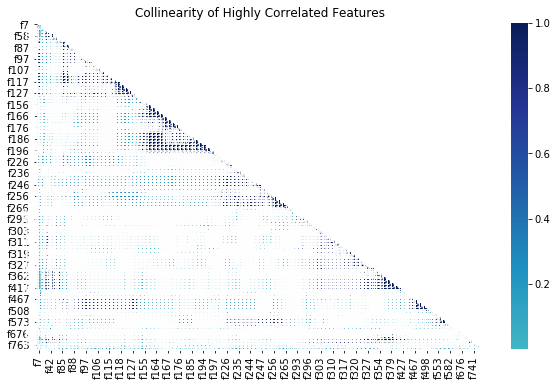

In [7]:
heatmap_of_correlation(cor_pearson, 0.99999999998)

In [5]:
def pca_computation(df, target_col):
    """
    Given dataset and target variable, plots 2d and 3d graphs for
    the first 2 or 3 reduced features respectively.
    The lighter colors correspond to the positive points.
    """
    
    # Normalize features
    features_df = df.drop(columns=[target_col, "id"])
    scaled_data = StandardScaler().fit_transform(features_df)
    
    # Get reduced features
    pca_res = pd.DataFrame()
    pca = PCA(n_components=100)
    pca_result = pca.fit_transform(scaled_data)
    pca_res['pca-one'] = pca_result[:,0]
    pca_res['pca-two'] = pca_result[:,1] 
    pca_res['pca-three'] = pca_result[:,2]
    pca_res["y"] = np.clip(df[target_col], 0, 1)
    print("Explained variation per principal component:", pca.explained_variance_ratio_.sum(), pca.n_components)

    # Plot 2-d graphs of 1st and 2nd components
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(pca_res['pca-one'], 
               pca_res['pca-two'], 
               s = 50, c=pca_res['y'])
    ax.grid()
    plt.show()
    
    # Plot 3-d graphs of 1st to 3rd components
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=pca_res.loc[:]["pca-one"], 
        ys=pca_res.loc[:]["pca-two"], 
        zs=pca_res.loc[:]["pca-three"], 
        c=pca_res.loc[:]["y"], 
        cmap='tab10'
    )
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()

Explained variation per principal component: 0.9055208447533771 100


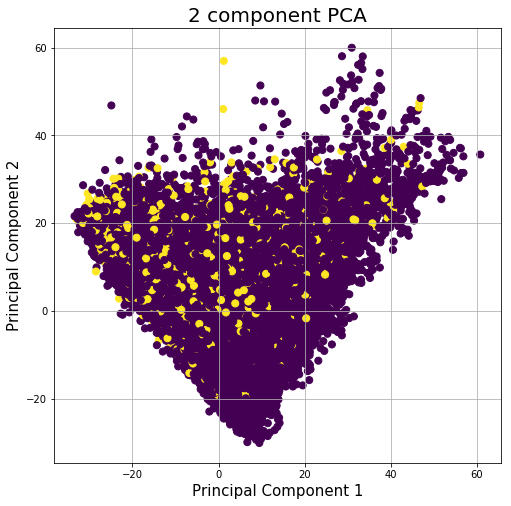

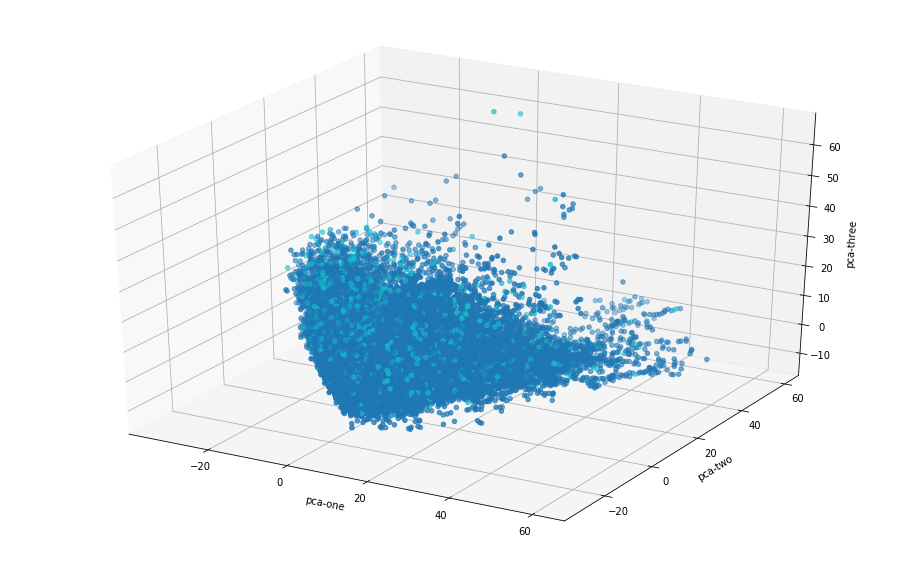

In [12]:
pca_computation(dropped_data, "loss")

# Data Modeling

### Note: This has changed to a classification problem

1. Random Forest/ Decision Tree

2. Support Vector Machine

3. K-NN Classifier

4. Linear Regression

5. Kernel Approximation

6. Stochastic Gradient Descent

### Previous Models

1. XG Boost Regressor

2. Random Forest Regressor

In [103]:
from sklearn.model_selection import GridSearchCV
def get_best_features(X, num_features):
    """
    Reduce features to num_features
    """
    print("Starting PCA computation...")
    pca = PCA(n_components=num_features)
    pca_result = pca.fit_transform(X)
    print("Explained Variance:", pca.explained_variance_ratio_.sum())
    return pca_result

def down_sample(X, y):
    """
    Down sample data to have equal numbers of 
    positive and negative target variables.
    """
    print("Starting down sampling...")
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    count = y.sum()
    indices0 = np.where(y == 0.0)[0]
    samples0 = random.choices(indices0, k=int(count))
    samples1 = list(np.where(y > 0)[0])
    samples0.extend(samples1)
    return X.iloc[samples0], y.iloc[samples0]

def prep_modeling(df, target):
    """
    Given dataframe and name of target column
    Creates a training, testing and validation set
    with ratios 4:3:3.
    Clips the target variable to binary.
    """
    print("Starting data splitting...")
    X = df.drop(columns=[target])
    y = df[target]
    for col in X.columns:
        if X[col].dtype != "int8" and col != "id":
            sd = data[col].std()
            if sd != 0:
                X[col] = (X[col] - data[col].mean())/sd
    Xtrain, Xtest = train_test_split(X, test_size=0.6)
    Xtest, Xval = train_test_split(Xtest, test_size=0.5)
    ytrain, ytest = train_test_split(y, test_size=0.6)
    ytest, yval = train_test_split(ytest, test_size=0.5)
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

def check_predictions(ypred, yset, oob=False):
    """
    Check distribution and MAE score of the predicted
    values given by model on the test set.
    """
    print("MAE: ", mean_absolute_error(yset, ypred))

    plt.hist(ypred)
    plt.title('Distribution of prediction Variable')
    plt.show()

    plt.hist(yset)
    plt.title('Distribution of actual Variable')
    plt.show()

def create_and_fit_model(model_type, X, y):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    clf = None
    if model_type == 0:
        clf = RandomForestClassifier(verbose=True) # Rand Forest
    elif model_type == 1:
        clf = DecisionTreeClassifier()
    elif model_type == 2:
        clf = SVC(gamma='auto', verbose=True) # SVC
    elif model_type == 3:
        clf = KNeighborsClassifier() # KNN
    elif model_type == 4:
        clf = LogisticRegression(verbose=True) # Lin Reg
    elif model_type == 6:
        clf = SGDClassifier(verbose=True)  # SGD
    
    if clf is not None:
        clf.fit(X, y)
        
    return clf

def create_combined_model(clf_type, regr_type, X, y, Xe, ye):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    Xr = X[y >0]
    yr = y[y>0]
    
    Xer = Xe[ye >0]
    yer = ye[ye>0]
    
    ts = time.time() 
    
    clf = None
    model = None
    
    if clf_type == 0:
        clf = IsolationForest(contamination=0.1, behaviour="new").fit(X)
    elif clf_type == 1:
        clf = KNeighborsClassifier(n_neighbors=2)
        clf.fit(X, y)
    
    if regr_type == 0:

        model = XGBRegressor(
            max_depth=10,
            n_estimators=1000,
            min_child_weight=0.5, 
            colsample_bytree=0.8, 
            subsample=0.8, 
            eta=0.01,
            seed=42)

        model.fit(
            Xr, 
            yr, 
            eval_metric="rmse", 
            eval_set=[(Xr, yr), (Xer, yer)], 
            verbose=True, 
            early_stopping_rounds = 20)
        
    elif regr_type == 1:
        
        model = DecisionTreeClassifier(max_leaf_nodes=100, max_depth=10, criterion="entropy")
        model.fit(Xr, yr)
    

    print("Training time:", time.time() - ts)
        
    return clf, model

def hyperparameter_tuning(model, X, y):
    
    parameters = {'criterion':('gini', 'entropy'), 
                  'max_depth':range(1, 10), 
                  "min_sample_splits":range(1, 10), 
                  "min_samples_leaf":range(1, 5)}
    grid = GridSearchCV(model, parameters)
    grid.fit(X, y)
    return grid

def predict_on_model(models, X, num_models=1):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    if num_models == 2:
        ypred1 = models[0].predict(X)
        ypred1[ypred1 > 0] = 0
        ypred1[ypred1 < 0] = 1
        interval = ypred1.copy()
        X_filtered = X[ypred1 > 0]
        ypred2 = models[1].predict(X_filtered).astype(int)
        ypred1[ypred1 > 0] = ypred2
        return ypred1, interval
    else:
        ypred = models.predict(X)
        return ypred
        


In [8]:
dropped_data["loss"] = data["loss"]
Xtrain, Xtest, Xval, ytrain, ytest, yval = prep_modeling(dropped_data, "loss")
Xtrain_down, ytrain_down = down_sample(Xtrain, ytrain)
Xtest_down, ytest_down = down_sample(Xtest, ytest)
Xval_down, yval_down = down_sample(Xval, yval)

Starting data splitting...
Starting down sampling...
Starting down sampling...
Starting down sampling...


In [11]:
# "Learn" the mean from the training data
mean_train = np.mean(ytrain)

# Get predictions on the test set
baseline_predictions = np.ones(ytrain.shape) * mean_train
zero_predictions = np.zeros(ytrain.shape)

# Compute MAE
print("Training Set:")
mae_baseline = mean_absolute_error(ytrain, baseline_predictions)
print("Mean MAE is {:.2f}".format(mae_baseline))
mae_baseline = mean_absolute_error(ytrain, zero_predictions)
print("Zero MAE is {:.2f}".format(mae_baseline))

# Get predictions on the test set
baseline_predictions = np.ones(ytest.shape) * mean_train
zero_predictions = np.zeros(ytest.shape)

# Compute MAE
print("Testing Set:")
mae_baseline = mean_absolute_error(ytest, baseline_predictions)
print("Mean MAE is {:.2f}".format(mae_baseline))
mae_baseline = mean_absolute_error(ytest, zero_predictions)
print("Zero MAE is {:.2f}".format(mae_baseline))

# Get predictions on the test set
baseline_predictions = np.ones(yval.shape) * mean_train
zero_predictions = np.zeros(yval.shape)

# Compute MAE
print("Validation Set:")
mae_baseline = mean_absolute_error(yval, baseline_predictions)
print("Mean MAE is {:.2f}".format(mae_baseline))
mae_baseline = mean_absolute_error(yval, zero_predictions)
print("Zero MAE is {:.2f}".format(mae_baseline))

Training Set:
Mean MAE is 1.46
Zero MAE is 0.81
Testing Set:
Mean MAE is 1.44
Zero MAE is 0.78
Validation Set:
Mean MAE is 1.46
Zero MAE is 0.81


Decision Tree Model
MAE:  1.7752283429727254


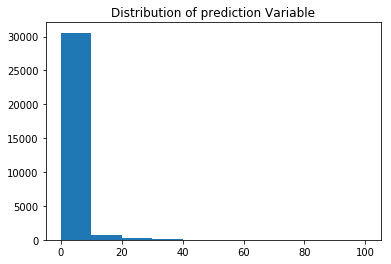

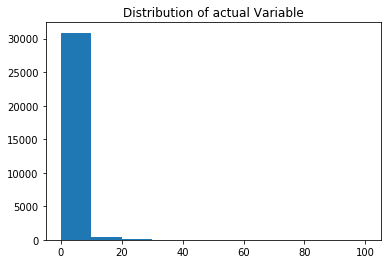


Random Forest Model


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE:  0.7858474763755886


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


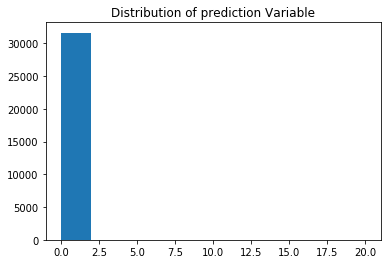

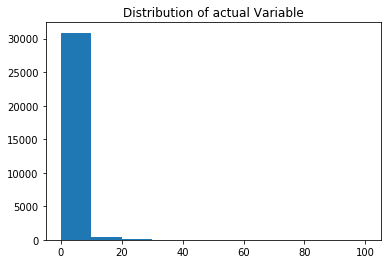


KNN Model
MAE:  0.7822761606776019


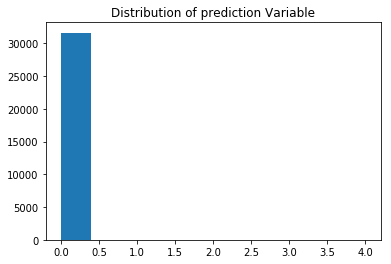

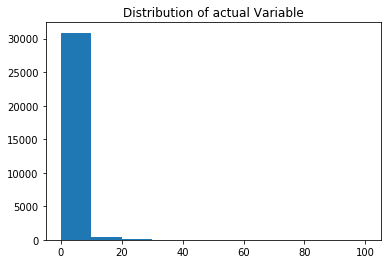


Logistic Regression Model


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[LibLinear]MAE:  0.8096773174046332


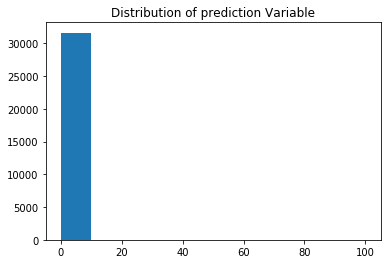

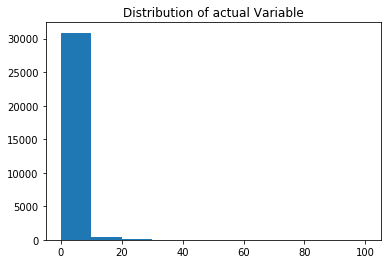


Support Vector Model
[LibSVM]MAE:  0.7817388830947188


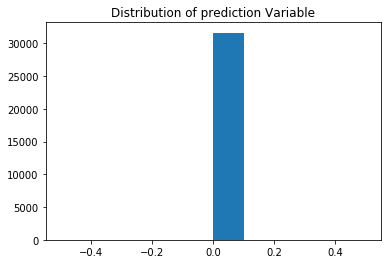

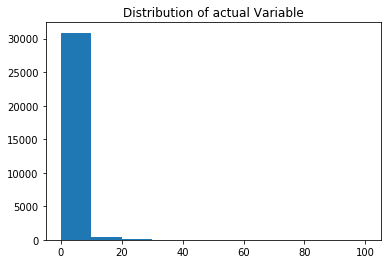


Stochastic Gradient Descent


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 189.83, NNZs: 608, Bias: 9.826403, T: 42188, Avg. loss: 1317.624852
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 135.66, NNZs: 611, Bias: 10.557585, T: 84376, Avg. loss: 243.027557
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 104.37, NNZs: 613, Bias: 9.747684, T: 126564, Avg. loss: 144.550035
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 88.66, NNZs: 617, Bias: 10.017638, T: 168752, Avg. loss: 101.800314
Total training time: 0.18 seconds.
-- Epoch 5
Norm: 75.24, NNZs: 617, Bias: 10.202972, T: 210940, Avg. loss: 79.167770
Total training time: 0.23 seconds.
-- Epoch 6
Norm: 70.39, NNZs: 618, Bias: 10.591126, T: 253128, Avg. loss: 63.693997
Total training time: 0.28 seconds.
-- Epoch 7
Norm: 64.41, NNZs: 618, Bias: 10.710145, T: 295316, Avg. loss: 54.514323
Total training time: 0.32 seconds.
-- Epoch 8
Norm: 59.89, NNZs: 618, Bias: 10.704709, T: 337504, Avg. loss: 47.554444
Total training time: 0.37 seconds.
-- Epoch 9
Norm: 56.84, NNZs: 618, Bias: 10.

Norm: 18.35, NNZs: 621, Bias: 10.425180, T: 2953160, Avg. loss: 5.297095
Total training time: 3.24 seconds.
-- Epoch 71
Norm: 18.10, NNZs: 621, Bias: 10.435256, T: 2995348, Avg. loss: 5.209497
Total training time: 3.29 seconds.
-- Epoch 72
Norm: 17.97, NNZs: 621, Bias: 10.425281, T: 3037536, Avg. loss: 5.196980
Total training time: 3.33 seconds.
-- Epoch 73
Norm: 17.77, NNZs: 621, Bias: 10.418777, T: 3079724, Avg. loss: 5.082408
Total training time: 3.38 seconds.
-- Epoch 74
Norm: 17.68, NNZs: 621, Bias: 10.418754, T: 3121912, Avg. loss: 5.075838
Total training time: 3.43 seconds.
-- Epoch 75
Norm: 17.59, NNZs: 621, Bias: 10.415645, T: 3164100, Avg. loss: 4.945731
Total training time: 3.47 seconds.
-- Epoch 76
Norm: 17.44, NNZs: 621, Bias: 10.434465, T: 3206288, Avg. loss: 4.851725
Total training time: 3.52 seconds.
-- Epoch 77
Norm: 17.35, NNZs: 621, Bias: 10.412746, T: 3248476, Avg. loss: 4.818758
Total training time: 3.56 seconds.
-- Epoch 78
Norm: 17.29, NNZs: 621, Bias: 10.403659,

Norm: 12.48, NNZs: 621, Bias: 10.265536, T: 5906320, Avg. loss: 2.769388
Total training time: 6.43 seconds.
-- Epoch 141
Norm: 12.43, NNZs: 621, Bias: 10.267241, T: 5948508, Avg. loss: 2.721849
Total training time: 6.48 seconds.
-- Epoch 142
Norm: 12.40, NNZs: 621, Bias: 10.258856, T: 5990696, Avg. loss: 2.667960
Total training time: 6.52 seconds.
-- Epoch 143
Norm: 12.36, NNZs: 621, Bias: 10.265513, T: 6032884, Avg. loss: 2.682561
Total training time: 6.57 seconds.
-- Epoch 144
Norm: 12.34, NNZs: 621, Bias: 10.258905, T: 6075072, Avg. loss: 2.693537
Total training time: 6.61 seconds.
-- Epoch 145
Norm: 12.27, NNZs: 621, Bias: 10.255636, T: 6117260, Avg. loss: 2.630351
Total training time: 6.66 seconds.
-- Epoch 146
Norm: 12.23, NNZs: 621, Bias: 10.258916, T: 6159448, Avg. loss: 2.648037
Total training time: 6.71 seconds.
-- Epoch 147
Norm: 12.19, NNZs: 621, Bias: 10.258924, T: 6201636, Avg. loss: 2.637302
Total training time: 6.75 seconds.
-- Epoch 148
Norm: 12.17, NNZs: 621, Bias: 10

Norm: 10.05, NNZs: 621, Bias: 10.156686, T: 8859480, Avg. loss: 1.901118
Total training time: 9.60 seconds.
-- Epoch 211
Norm: 10.02, NNZs: 621, Bias: 10.161174, T: 8901668, Avg. loss: 1.904829
Total training time: 9.65 seconds.
-- Epoch 212
Norm: 9.99, NNZs: 621, Bias: 10.156700, T: 8943856, Avg. loss: 1.880474
Total training time: 9.69 seconds.
-- Epoch 213
Norm: 9.98, NNZs: 621, Bias: 10.160043, T: 8986044, Avg. loss: 1.848718
Total training time: 9.74 seconds.
-- Epoch 214
Norm: 9.98, NNZs: 621, Bias: 10.155589, T: 9028232, Avg. loss: 1.872391
Total training time: 9.78 seconds.
-- Epoch 215
Norm: 9.94, NNZs: 621, Bias: 10.153381, T: 9070420, Avg. loss: 1.874335
Total training time: 9.83 seconds.
-- Epoch 216
Norm: 9.90, NNZs: 621, Bias: 10.155586, T: 9112608, Avg. loss: 1.846694
Total training time: 9.87 seconds.
-- Epoch 217
Norm: 9.85, NNZs: 621, Bias: 10.155591, T: 9154796, Avg. loss: 1.846137
Total training time: 9.92 seconds.
-- Epoch 218
Norm: 9.85, NNZs: 621, Bias: 10.146869

Norm: 8.69, NNZs: 621, Bias: 10.070319, T: 11812640, Avg. loss: 1.486897
Total training time: 12.80 seconds.
-- Epoch 281
Norm: 8.67, NNZs: 621, Bias: 10.072854, T: 11854828, Avg. loss: 1.475005
Total training time: 12.85 seconds.
Convergence after 281 epochs took 12.85 seconds
-- Epoch 1
Norm: 132.71, NNZs: 583, Bias: -15.003287, T: 42188, Avg. loss: 151.295555
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 84.06, NNZs: 596, Bias: -14.917323, T: 84376, Avg. loss: 31.555964
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 71.46, NNZs: 602, Bias: -15.141064, T: 126564, Avg. loss: 18.430299
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 54.88, NNZs: 603, Bias: -15.288522, T: 168752, Avg. loss: 12.987639
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 48.08, NNZs: 604, Bias: -15.122142, T: 210940, Avg. loss: 10.167465
Total training time: 0.20 seconds.
-- Epoch 6
Norm: 45.38, NNZs: 604, Bias: -15.330491, T: 253128, Avg. loss: 8.244082
Total training time: 0.24 seconds.
--

Norm: 14.86, NNZs: 614, Bias: -15.449239, T: 2826596, Avg. loss: 0.682238
Total training time: 2.66 seconds.
-- Epoch 68
Norm: 14.71, NNZs: 614, Bias: -15.438704, T: 2868784, Avg. loss: 0.687575
Total training time: 2.70 seconds.
-- Epoch 69
Norm: 14.61, NNZs: 614, Bias: -15.442142, T: 2910972, Avg. loss: 0.672564
Total training time: 2.74 seconds.
-- Epoch 70
Norm: 14.48, NNZs: 614, Bias: -15.445623, T: 2953160, Avg. loss: 0.654014
Total training time: 2.78 seconds.
-- Epoch 71
Norm: 14.38, NNZs: 614, Bias: -15.448945, T: 2995348, Avg. loss: 0.670828
Total training time: 2.82 seconds.
-- Epoch 72
Norm: 14.29, NNZs: 614, Bias: -15.442306, T: 3037536, Avg. loss: 0.656403
Total training time: 2.86 seconds.
-- Epoch 73
Norm: 14.20, NNZs: 614, Bias: -15.432520, T: 3079724, Avg. loss: 0.638324
Total training time: 2.90 seconds.
-- Epoch 74
Norm: 14.10, NNZs: 614, Bias: -15.432460, T: 3121912, Avg. loss: 0.629695
Total training time: 2.94 seconds.
-- Epoch 75
Norm: 13.97, NNZs: 614, Bias: -1

Norm: 10.30, NNZs: 617, Bias: -15.346551, T: 5864132, Avg. loss: 0.341875
Total training time: 5.51 seconds.
-- Epoch 140
Norm: 10.26, NNZs: 617, Bias: -15.348270, T: 5906320, Avg. loss: 0.343281
Total training time: 5.55 seconds.
-- Epoch 141
Norm: 10.21, NNZs: 617, Bias: -15.348260, T: 5948508, Avg. loss: 0.341078
Total training time: 5.59 seconds.
-- Epoch 142
Norm: 10.19, NNZs: 617, Bias: -15.344902, T: 5990696, Avg. loss: 0.344378
Total training time: 5.63 seconds.
-- Epoch 143
Norm: 10.13, NNZs: 617, Bias: -15.343248, T: 6032884, Avg. loss: 0.340364
Total training time: 5.67 seconds.
-- Epoch 144
Norm: 10.10, NNZs: 617, Bias: -15.339941, T: 6075072, Avg. loss: 0.334015
Total training time: 5.71 seconds.
-- Epoch 145
Norm: 10.06, NNZs: 617, Bias: -15.339939, T: 6117260, Avg. loss: 0.334953
Total training time: 5.75 seconds.
-- Epoch 146
Norm: 10.00, NNZs: 617, Bias: -15.339941, T: 6159448, Avg. loss: 0.331894
Total training time: 5.80 seconds.
-- Epoch 147
Norm: 10.00, NNZs: 617, 

Norm: 20.12, NNZs: 611, Bias: -17.030542, T: 1392204, Avg. loss: 1.525335
Total training time: 1.30 seconds.
-- Epoch 34
Norm: 19.90, NNZs: 611, Bias: -17.023532, T: 1434392, Avg. loss: 1.485434
Total training time: 1.34 seconds.
-- Epoch 35
Norm: 19.67, NNZs: 611, Bias: -17.023548, T: 1476580, Avg. loss: 1.447392
Total training time: 1.38 seconds.
-- Epoch 36
Norm: 19.35, NNZs: 612, Bias: -17.050298, T: 1518768, Avg. loss: 1.409944
Total training time: 1.42 seconds.
-- Epoch 37
Norm: 19.28, NNZs: 612, Bias: -17.043849, T: 1560956, Avg. loss: 1.366394
Total training time: 1.46 seconds.
-- Epoch 38
Norm: 19.09, NNZs: 612, Bias: -17.062690, T: 1603144, Avg. loss: 1.324783
Total training time: 1.50 seconds.
-- Epoch 39
Norm: 18.79, NNZs: 612, Bias: -17.062657, T: 1645332, Avg. loss: 1.287862
Total training time: 1.54 seconds.
-- Epoch 40
Norm: 18.70, NNZs: 612, Bias: -17.086499, T: 1687520, Avg. loss: 1.259092
Total training time: 1.58 seconds.
-- Epoch 41
Norm: 18.31, NNZs: 612, Bias: -1

Norm: 11.52, NNZs: 618, Bias: -17.222971, T: 4429740, Avg. loss: 0.486323
Total training time: 4.16 seconds.
-- Epoch 106
Norm: 11.44, NNZs: 618, Bias: -17.220708, T: 4471928, Avg. loss: 0.486933
Total training time: 4.20 seconds.
-- Epoch 107
Norm: 11.39, NNZs: 618, Bias: -17.218505, T: 4514116, Avg. loss: 0.480399
Total training time: 4.24 seconds.
-- Epoch 108
Norm: 11.33, NNZs: 618, Bias: -17.222915, T: 4556304, Avg. loss: 0.486452
Total training time: 4.28 seconds.
-- Epoch 109
Norm: 11.26, NNZs: 618, Bias: -17.220714, T: 4598492, Avg. loss: 0.468928
Total training time: 4.32 seconds.
-- Epoch 110
Norm: 11.22, NNZs: 618, Bias: -17.227202, T: 4640680, Avg. loss: 0.460022
Total training time: 4.36 seconds.
-- Epoch 111
Norm: 11.16, NNZs: 618, Bias: -17.220777, T: 4682868, Avg. loss: 0.461362
Total training time: 4.40 seconds.
-- Epoch 112
Norm: 11.13, NNZs: 618, Bias: -17.220802, T: 4725056, Avg. loss: 0.461285
Total training time: 4.44 seconds.
-- Epoch 113
Norm: 11.06, NNZs: 618, 

Norm: 9.01, NNZs: 618, Bias: -17.217328, T: 7340712, Avg. loss: 0.299841
Total training time: 6.90 seconds.
-- Epoch 175
Norm: 8.94, NNZs: 618, Bias: -17.220046, T: 7382900, Avg. loss: 0.308438
Total training time: 6.93 seconds.
-- Epoch 176
Norm: 8.91, NNZs: 618, Bias: -17.222746, T: 7425088, Avg. loss: 0.308389
Total training time: 6.97 seconds.
-- Epoch 177
Norm: 8.87, NNZs: 618, Bias: -17.221403, T: 7467276, Avg. loss: 0.298398
Total training time: 7.01 seconds.
-- Epoch 178
Norm: 8.83, NNZs: 618, Bias: -17.220065, T: 7509464, Avg. loss: 0.298609
Total training time: 7.05 seconds.
-- Epoch 179
Norm: 8.82, NNZs: 618, Bias: -17.213424, T: 7551652, Avg. loss: 0.298586
Total training time: 7.09 seconds.
-- Epoch 180
Norm: 8.77, NNZs: 618, Bias: -17.216058, T: 7593840, Avg. loss: 0.296419
Total training time: 7.13 seconds.
-- Epoch 181
Norm: 8.75, NNZs: 618, Bias: -17.213432, T: 7636028, Avg. loss: 0.300685
Total training time: 7.17 seconds.
-- Epoch 182
Norm: 8.74, NNZs: 618, Bias: -17

Norm: 26.91, NNZs: 610, Bias: -17.900226, T: 759384, Avg. loss: 2.457276
Total training time: 0.96 seconds.
-- Epoch 19
Norm: 26.22, NNZs: 610, Bias: -17.899270, T: 801572, Avg. loss: 2.316942
Total training time: 1.00 seconds.
-- Epoch 20
Norm: 25.64, NNZs: 610, Bias: -17.923347, T: 843760, Avg. loss: 2.215199
Total training time: 1.04 seconds.
-- Epoch 21
Norm: 24.97, NNZs: 611, Bias: -17.877229, T: 885948, Avg. loss: 2.124919
Total training time: 1.08 seconds.
-- Epoch 22
Norm: 24.45, NNZs: 611, Bias: -17.921656, T: 928136, Avg. loss: 2.020691
Total training time: 1.12 seconds.
-- Epoch 23
Norm: 23.86, NNZs: 611, Bias: -17.911420, T: 970324, Avg. loss: 1.916455
Total training time: 1.16 seconds.
-- Epoch 24
Norm: 23.30, NNZs: 611, Bias: -17.911856, T: 1012512, Avg. loss: 1.856104
Total training time: 1.20 seconds.
-- Epoch 25
Norm: 22.96, NNZs: 611, Bias: -17.912736, T: 1054700, Avg. loss: 1.780889
Total training time: 1.24 seconds.
-- Epoch 26
Norm: 22.56, NNZs: 611, Bias: -17.9320

Norm: 11.89, NNZs: 618, Bias: -17.993651, T: 3796920, Avg. loss: 0.504406
Total training time: 4.08 seconds.
-- Epoch 91
Norm: 11.86, NNZs: 618, Bias: -18.001491, T: 3839108, Avg. loss: 0.484930
Total training time: 4.12 seconds.
-- Epoch 92
Norm: 11.81, NNZs: 618, Bias: -17.996278, T: 3881296, Avg. loss: 0.487178
Total training time: 4.16 seconds.
-- Epoch 93
Norm: 11.75, NNZs: 618, Bias: -17.988547, T: 3923484, Avg. loss: 0.487018
Total training time: 4.20 seconds.
-- Epoch 94
Norm: 11.68, NNZs: 618, Bias: -17.985996, T: 3965672, Avg. loss: 0.473051
Total training time: 4.24 seconds.
-- Epoch 95
Norm: 11.59, NNZs: 618, Bias: -17.991012, T: 4007860, Avg. loss: 0.468798
Total training time: 4.28 seconds.
-- Epoch 96
Norm: 11.54, NNZs: 618, Bias: -17.988524, T: 4050048, Avg. loss: 0.468189
Total training time: 4.32 seconds.
-- Epoch 97
Norm: 11.49, NNZs: 618, Bias: -17.990966, T: 4092236, Avg. loss: 0.464791
Total training time: 4.37 seconds.
-- Epoch 98
Norm: 11.41, NNZs: 618, Bias: -1

Norm: 8.87, NNZs: 618, Bias: -17.951820, T: 6750080, Avg. loss: 0.284219
Total training time: 7.08 seconds.
-- Epoch 161
Norm: 8.87, NNZs: 618, Bias: -17.950348, T: 6792268, Avg. loss: 0.282781
Total training time: 7.13 seconds.
-- Epoch 162
Norm: 8.84, NNZs: 618, Bias: -17.954751, T: 6834456, Avg. loss: 0.279129
Total training time: 7.17 seconds.
-- Epoch 163
Norm: 8.82, NNZs: 618, Bias: -17.950373, T: 6876644, Avg. loss: 0.286284
Total training time: 7.22 seconds.
-- Epoch 164
Norm: 8.79, NNZs: 618, Bias: -17.951828, T: 6918832, Avg. loss: 0.280412
Total training time: 7.26 seconds.
-- Epoch 165
Norm: 8.77, NNZs: 618, Bias: -17.948937, T: 6961020, Avg. loss: 0.278682
Total training time: 7.31 seconds.
-- Epoch 166
Norm: 8.75, NNZs: 618, Bias: -17.947512, T: 7003208, Avg. loss: 0.276998
Total training time: 7.37 seconds.
-- Epoch 167
Norm: 8.73, NNZs: 618, Bias: -17.948942, T: 7045396, Avg. loss: 0.275101
Total training time: 7.41 seconds.
-- Epoch 168
Norm: 8.68, NNZs: 618, Bias: -17

Norm: 21.13, NNZs: 610, Bias: -12.077193, T: 1096888, Avg. loss: 1.635144
Total training time: 1.17 seconds.
-- Epoch 27
Norm: 20.81, NNZs: 610, Bias: -12.059555, T: 1139076, Avg. loss: 1.611036
Total training time: 1.21 seconds.
-- Epoch 28
Norm: 20.56, NNZs: 610, Bias: -12.059352, T: 1181264, Avg. loss: 1.505676
Total training time: 1.26 seconds.
-- Epoch 29
Norm: 19.90, NNZs: 612, Bias: -12.034407, T: 1223452, Avg. loss: 1.446884
Total training time: 1.30 seconds.
-- Epoch 30
Norm: 19.59, NNZs: 612, Bias: -12.042685, T: 1265640, Avg. loss: 1.401725
Total training time: 1.34 seconds.
-- Epoch 31
Norm: 19.35, NNZs: 612, Bias: -12.042718, T: 1307828, Avg. loss: 1.382358
Total training time: 1.39 seconds.
-- Epoch 32
Norm: 19.20, NNZs: 612, Bias: -12.020205, T: 1350016, Avg. loss: 1.319651
Total training time: 1.43 seconds.
-- Epoch 33
Norm: 19.02, NNZs: 612, Bias: -11.998672, T: 1392204, Avg. loss: 1.258695
Total training time: 1.47 seconds.
-- Epoch 34
Norm: 18.65, NNZs: 612, Bias: -1

Norm: 12.05, NNZs: 614, Bias: -11.891042, T: 4007860, Avg. loss: 0.449009
Total training time: 4.54 seconds.
-- Epoch 96
Norm: 12.03, NNZs: 614, Bias: -11.888564, T: 4050048, Avg. loss: 0.446416
Total training time: 4.58 seconds.
-- Epoch 97
Norm: 11.95, NNZs: 614, Bias: -11.888583, T: 4092236, Avg. loss: 0.440071
Total training time: 4.62 seconds.
-- Epoch 98
Norm: 11.87, NNZs: 614, Bias: -11.886155, T: 4134424, Avg. loss: 0.442046
Total training time: 4.66 seconds.
-- Epoch 99
Norm: 11.82, NNZs: 614, Bias: -11.883748, T: 4176612, Avg. loss: 0.434843
Total training time: 4.70 seconds.
-- Epoch 100
Norm: 11.71, NNZs: 614, Bias: -11.888537, T: 4218800, Avg. loss: 0.431533
Total training time: 4.74 seconds.
-- Epoch 101
Norm: 11.66, NNZs: 614, Bias: -11.893249, T: 4260988, Avg. loss: 0.428266
Total training time: 4.78 seconds.
-- Epoch 102
Norm: 11.63, NNZs: 615, Bias: -11.881570, T: 4303176, Avg. loss: 0.422679
Total training time: 4.82 seconds.
-- Epoch 103
Norm: 11.58, NNZs: 615, Bias

Norm: 9.16, NNZs: 619, Bias: -11.821398, T: 6961020, Avg. loss: 0.270217
Total training time: 7.77 seconds.
-- Epoch 166
Norm: 9.13, NNZs: 619, Bias: -11.819952, T: 7003208, Avg. loss: 0.266505
Total training time: 7.81 seconds.
-- Epoch 167
Norm: 9.11, NNZs: 619, Bias: -11.815677, T: 7045396, Avg. loss: 0.263543
Total training time: 7.85 seconds.
-- Epoch 168
Norm: 9.07, NNZs: 619, Bias: -11.817087, T: 7087584, Avg. loss: 0.264626
Total training time: 7.89 seconds.
-- Epoch 169
Norm: 9.04, NNZs: 619, Bias: -11.819900, T: 7129772, Avg. loss: 0.261189
Total training time: 7.93 seconds.
-- Epoch 170
Norm: 9.02, NNZs: 619, Bias: -11.819899, T: 7171960, Avg. loss: 0.260040
Total training time: 7.97 seconds.
-- Epoch 171
Norm: 8.98, NNZs: 619, Bias: -11.819892, T: 7214148, Avg. loss: 0.259657
Total training time: 8.01 seconds.
-- Epoch 172
Norm: 8.96, NNZs: 619, Bias: -11.818506, T: 7256336, Avg. loss: 0.260374
Total training time: 8.04 seconds.
-- Epoch 173
Norm: 8.93, NNZs: 619, Bias: -11

Norm: 15.97, NNZs: 617, Bias: -13.976662, T: 1982836, Avg. loss: 0.612375
Total training time: 1.86 seconds.
-- Epoch 48
Norm: 15.85, NNZs: 617, Bias: -13.981641, T: 2025024, Avg. loss: 0.605730
Total training time: 1.90 seconds.
-- Epoch 49
Norm: 15.64, NNZs: 617, Bias: -13.967077, T: 2067212, Avg. loss: 0.592560
Total training time: 1.94 seconds.
-- Epoch 50
Norm: 15.46, NNZs: 617, Bias: -13.962231, T: 2109400, Avg. loss: 0.587504
Total training time: 1.98 seconds.
-- Epoch 51
Norm: 15.37, NNZs: 617, Bias: -13.966952, T: 2151588, Avg. loss: 0.573977
Total training time: 2.02 seconds.
-- Epoch 52
Norm: 15.28, NNZs: 617, Bias: -13.962375, T: 2193776, Avg. loss: 0.541918
Total training time: 2.06 seconds.
-- Epoch 53
Norm: 15.23, NNZs: 617, Bias: -13.962356, T: 2235964, Avg. loss: 0.536210
Total training time: 2.11 seconds.
-- Epoch 54
Norm: 15.01, NNZs: 617, Bias: -13.962317, T: 2278152, Avg. loss: 0.547628
Total training time: 2.15 seconds.
-- Epoch 55
Norm: 14.89, NNZs: 617, Bias: -1

Norm: 10.42, NNZs: 618, Bias: -13.907160, T: 5020372, Avg. loss: 0.247642
Total training time: 4.70 seconds.
-- Epoch 120
Norm: 10.37, NNZs: 618, Bias: -13.903196, T: 5062560, Avg. loss: 0.249916
Total training time: 4.75 seconds.
-- Epoch 121
Norm: 10.31, NNZs: 618, Bias: -13.899274, T: 5104748, Avg. loss: 0.242396
Total training time: 4.79 seconds.
-- Epoch 122
Norm: 10.26, NNZs: 618, Bias: -13.903166, T: 5146936, Avg. loss: 0.246210
Total training time: 4.82 seconds.
-- Epoch 123
Norm: 10.22, NNZs: 618, Bias: -13.903175, T: 5189124, Avg. loss: 0.241345
Total training time: 4.87 seconds.
-- Epoch 124
Norm: 10.17, NNZs: 618, Bias: -13.899345, T: 5231312, Avg. loss: 0.249389
Total training time: 4.90 seconds.
-- Epoch 125
Norm: 10.12, NNZs: 618, Bias: -13.897428, T: 5273500, Avg. loss: 0.243082
Total training time: 4.94 seconds.
-- Epoch 126
Norm: 10.07, NNZs: 618, Bias: -13.899319, T: 5315688, Avg. loss: 0.231518
Total training time: 4.98 seconds.
-- Epoch 127
Norm: 10.04, NNZs: 618, 

Norm: 14.25, NNZs: 612, Bias: -17.289379, T: 2320340, Avg. loss: 0.449133
Total training time: 2.14 seconds.
-- Epoch 56
Norm: 14.13, NNZs: 612, Bias: -17.285114, T: 2362528, Avg. loss: 0.454956
Total training time: 2.18 seconds.
-- Epoch 57
Norm: 14.04, NNZs: 612, Bias: -17.280978, T: 2404716, Avg. loss: 0.434453
Total training time: 2.22 seconds.
-- Epoch 58
Norm: 13.99, NNZs: 613, Bias: -17.281041, T: 2446904, Avg. loss: 0.435624
Total training time: 2.26 seconds.
-- Epoch 59
Norm: 13.87, NNZs: 613, Bias: -17.281093, T: 2489092, Avg. loss: 0.427422
Total training time: 2.30 seconds.
-- Epoch 60
Norm: 13.78, NNZs: 613, Bias: -17.277117, T: 2531280, Avg. loss: 0.424044
Total training time: 2.34 seconds.
-- Epoch 61
Norm: 13.76, NNZs: 613, Bias: -17.281037, T: 2573468, Avg. loss: 0.410373
Total training time: 2.38 seconds.
-- Epoch 62
Norm: 13.65, NNZs: 613, Bias: -17.281005, T: 2615656, Avg. loss: 0.414466
Total training time: 2.41 seconds.
-- Epoch 63
Norm: 13.56, NNZs: 613, Bias: -1

Norm: 43.85, NNZs: 598, Bias: -12.291493, T: 168752, Avg. loss: 6.463903
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 39.46, NNZs: 599, Bias: -12.297094, T: 210940, Avg. loss: 5.135729
Total training time: 0.20 seconds.
-- Epoch 6
Norm: 35.27, NNZs: 600, Bias: -12.208757, T: 253128, Avg. loss: 4.227596
Total training time: 0.24 seconds.
-- Epoch 7
Norm: 31.84, NNZs: 601, Bias: -12.246843, T: 295316, Avg. loss: 3.616181
Total training time: 0.28 seconds.
-- Epoch 8
Norm: 31.43, NNZs: 603, Bias: -12.340113, T: 337504, Avg. loss: 3.070589
Total training time: 0.32 seconds.
-- Epoch 9
Norm: 28.54, NNZs: 605, Bias: -12.310940, T: 379692, Avg. loss: 2.702759
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 27.78, NNZs: 605, Bias: -12.282083, T: 421880, Avg. loss: 2.408569
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 27.46, NNZs: 605, Bias: -12.303869, T: 464068, Avg. loss: 2.182728
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 25.40, NNZs: 606, Bias: -12.262376, T: 

Norm: 12.18, NNZs: 612, Bias: -12.012737, T: 3164100, Avg. loss: 0.308002
Total training time: 2.93 seconds.
-- Epoch 76
Norm: 12.10, NNZs: 612, Bias: -12.009562, T: 3206288, Avg. loss: 0.315694
Total training time: 2.97 seconds.
-- Epoch 77
Norm: 12.05, NNZs: 612, Bias: -12.003376, T: 3248476, Avg. loss: 0.304051
Total training time: 3.01 seconds.
-- Epoch 78
Norm: 11.97, NNZs: 613, Bias: -12.003402, T: 3290664, Avg. loss: 0.296298
Total training time: 3.05 seconds.
-- Epoch 79
Norm: 11.86, NNZs: 613, Bias: -11.997342, T: 3332852, Avg. loss: 0.299715
Total training time: 3.09 seconds.
-- Epoch 80
Norm: 11.85, NNZs: 613, Bias: -12.000328, T: 3375040, Avg. loss: 0.281315
Total training time: 3.13 seconds.
-- Epoch 81
Norm: 11.78, NNZs: 613, Bias: -11.997365, T: 3417228, Avg. loss: 0.272520
Total training time: 3.16 seconds.
-- Epoch 82
Norm: 11.73, NNZs: 613, Bias: -11.994425, T: 3459416, Avg. loss: 0.277967
Total training time: 3.20 seconds.
-- Epoch 83
Norm: 11.64, NNZs: 613, Bias: -1

Norm: 13.73, NNZs: 608, Bias: -14.021498, T: 2573468, Avg. loss: 0.298711
Total training time: 2.38 seconds.
-- Epoch 62
Norm: 13.74, NNZs: 608, Bias: -14.029191, T: 2615656, Avg. loss: 0.284452
Total training time: 2.42 seconds.
-- Epoch 63
Norm: 13.64, NNZs: 608, Bias: -14.029182, T: 2657844, Avg. loss: 0.275612
Total training time: 2.46 seconds.
-- Epoch 64
Norm: 13.49, NNZs: 608, Bias: -14.025406, T: 2700032, Avg. loss: 0.280372
Total training time: 2.50 seconds.
-- Epoch 65
Norm: 13.36, NNZs: 608, Bias: -14.021781, T: 2742220, Avg. loss: 0.271693
Total training time: 2.53 seconds.
-- Epoch 66
Norm: 13.24, NNZs: 608, Bias: -14.021783, T: 2784408, Avg. loss: 0.272039
Total training time: 2.57 seconds.
-- Epoch 67
Norm: 13.13, NNZs: 608, Bias: -14.021817, T: 2826596, Avg. loss: 0.260871
Total training time: 2.61 seconds.
-- Epoch 68
Norm: 13.11, NNZs: 608, Bias: -14.018280, T: 2868784, Avg. loss: 0.259014
Total training time: 2.65 seconds.
-- Epoch 69
Norm: 12.97, NNZs: 608, Bias: -1

Norm: 9.80, NNZs: 613, Bias: -13.988216, T: 5611004, Avg. loss: 0.132173
Total training time: 5.16 seconds.
-- Epoch 134
Norm: 9.77, NNZs: 613, Bias: -13.989990, T: 5653192, Avg. loss: 0.133942
Total training time: 5.20 seconds.
-- Epoch 135
Norm: 9.73, NNZs: 613, Bias: -13.988228, T: 5695380, Avg. loss: 0.137863
Total training time: 5.24 seconds.
-- Epoch 136
Norm: 9.71, NNZs: 613, Bias: -13.982983, T: 5737568, Avg. loss: 0.133265
Total training time: 5.28 seconds.
-- Epoch 137
Norm: 9.67, NNZs: 613, Bias: -13.982986, T: 5779756, Avg. loss: 0.129584
Total training time: 5.32 seconds.
-- Epoch 138
Norm: 9.65, NNZs: 613, Bias: -13.979539, T: 5821944, Avg. loss: 0.131276
Total training time: 5.36 seconds.
-- Epoch 139
Norm: 9.60, NNZs: 613, Bias: -13.979551, T: 5864132, Avg. loss: 0.130180
Total training time: 5.40 seconds.
-- Epoch 140
Norm: 9.57, NNZs: 613, Bias: -13.982954, T: 5906320, Avg. loss: 0.127949
Total training time: 5.44 seconds.
-- Epoch 141
Norm: 9.56, NNZs: 613, Bias: -13

Norm: 14.56, NNZs: 605, Bias: -12.187081, T: 1476580, Avg. loss: 0.328590
Total training time: 1.36 seconds.
-- Epoch 36
Norm: 14.28, NNZs: 605, Bias: -12.180382, T: 1518768, Avg. loss: 0.304028
Total training time: 1.40 seconds.
-- Epoch 37
Norm: 14.09, NNZs: 605, Bias: -12.180233, T: 1560956, Avg. loss: 0.289811
Total training time: 1.44 seconds.
-- Epoch 38
Norm: 13.96, NNZs: 605, Bias: -12.180237, T: 1603144, Avg. loss: 0.294770
Total training time: 1.48 seconds.
-- Epoch 39
Norm: 13.91, NNZs: 606, Bias: -12.192618, T: 1645332, Avg. loss: 0.275643
Total training time: 1.51 seconds.
-- Epoch 40
Norm: 13.67, NNZs: 607, Bias: -12.186538, T: 1687520, Avg. loss: 0.284702
Total training time: 1.55 seconds.
-- Epoch 41
Norm: 13.62, NNZs: 608, Bias: -12.192469, T: 1729708, Avg. loss: 0.263454
Total training time: 1.59 seconds.
-- Epoch 42
Norm: 13.49, NNZs: 608, Bias: -12.198162, T: 1771896, Avg. loss: 0.252303
Total training time: 1.63 seconds.
-- Epoch 43
Norm: 13.36, NNZs: 608, Bias: -1

Norm: 8.94, NNZs: 612, Bias: -12.191886, T: 4514116, Avg. loss: 0.099733
Total training time: 4.15 seconds.
-- Epoch 108
Norm: 8.87, NNZs: 612, Bias: -12.191904, T: 4556304, Avg. loss: 0.103660
Total training time: 4.19 seconds.
-- Epoch 109
Norm: 8.84, NNZs: 612, Bias: -12.189721, T: 4598492, Avg. loss: 0.100997
Total training time: 4.23 seconds.
-- Epoch 110
Norm: 8.82, NNZs: 612, Bias: -12.187550, T: 4640680, Avg. loss: 0.098032
Total training time: 4.27 seconds.
-- Epoch 111
Norm: 8.79, NNZs: 612, Bias: -12.185401, T: 4682868, Avg. loss: 0.098618
Total training time: 4.31 seconds.
-- Epoch 112
Norm: 8.76, NNZs: 612, Bias: -12.185389, T: 4725056, Avg. loss: 0.095943
Total training time: 4.35 seconds.
-- Epoch 113
Norm: 8.72, NNZs: 612, Bias: -12.183282, T: 4767244, Avg. loss: 0.097262
Total training time: 4.38 seconds.
-- Epoch 114
Norm: 8.72, NNZs: 613, Bias: -12.183278, T: 4809432, Avg. loss: 0.094664
Total training time: 4.42 seconds.
-- Epoch 115
Norm: 8.70, NNZs: 613, Bias: -12

Norm: 12.74, NNZs: 610, Bias: -12.655177, T: 2278152, Avg. loss: 0.243680
Total training time: 2.09 seconds.
-- Epoch 55
Norm: 12.57, NNZs: 610, Bias: -12.659521, T: 2320340, Avg. loss: 0.248948
Total training time: 2.13 seconds.
-- Epoch 56
Norm: 12.58, NNZs: 610, Bias: -12.655295, T: 2362528, Avg. loss: 0.231687
Total training time: 2.17 seconds.
-- Epoch 57
Norm: 12.41, NNZs: 610, Bias: -12.655362, T: 2404716, Avg. loss: 0.225635
Total training time: 2.20 seconds.
-- Epoch 58
Norm: 12.32, NNZs: 610, Bias: -12.663625, T: 2446904, Avg. loss: 0.231032
Total training time: 2.24 seconds.
-- Epoch 59
Norm: 12.24, NNZs: 610, Bias: -12.655560, T: 2489092, Avg. loss: 0.230631
Total training time: 2.28 seconds.
-- Epoch 60
Norm: 12.14, NNZs: 610, Bias: -12.659540, T: 2531280, Avg. loss: 0.222557
Total training time: 2.32 seconds.
-- Epoch 61
Norm: 12.03, NNZs: 610, Bias: -12.667360, T: 2573468, Avg. loss: 0.200138
Total training time: 2.36 seconds.
-- Epoch 62
Norm: 11.86, NNZs: 610, Bias: -1

Norm: 11.88, NNZs: 604, Bias: -9.733318, T: 2531280, Avg. loss: 0.182186
Total training time: 2.34 seconds.
-- Epoch 61
Norm: 11.77, NNZs: 604, Bias: -9.729397, T: 2573468, Avg. loss: 0.180643
Total training time: 2.38 seconds.
-- Epoch 62
Norm: 11.75, NNZs: 604, Bias: -9.740943, T: 2615656, Avg. loss: 0.164764
Total training time: 2.41 seconds.
-- Epoch 63
Norm: 11.68, NNZs: 604, Bias: -9.748492, T: 2657844, Avg. loss: 0.168957
Total training time: 2.45 seconds.
-- Epoch 64
Norm: 11.63, NNZs: 604, Bias: -9.744815, T: 2700032, Avg. loss: 0.165090
Total training time: 2.49 seconds.
-- Epoch 65
Norm: 11.53, NNZs: 604, Bias: -9.752155, T: 2742220, Avg. loss: 0.170318
Total training time: 2.53 seconds.
-- Epoch 66
Norm: 11.43, NNZs: 604, Bias: -9.752107, T: 2784408, Avg. loss: 0.164564
Total training time: 2.57 seconds.
-- Epoch 67
Norm: 11.39, NNZs: 604, Bias: -9.752093, T: 2826596, Avg. loss: 0.153335
Total training time: 2.61 seconds.
-- Epoch 68
Norm: 11.31, NNZs: 604, Bias: -9.752100,

Norm: 11.42, NNZs: 607, Bias: -19.354369, T: 2489092, Avg. loss: 0.140384
Total training time: 2.32 seconds.
-- Epoch 60
Norm: 11.34, NNZs: 607, Bias: -19.358365, T: 2531280, Avg. loss: 0.127407
Total training time: 2.36 seconds.
-- Epoch 61
Norm: 11.19, NNZs: 607, Bias: -19.362277, T: 2573468, Avg. loss: 0.128947
Total training time: 2.40 seconds.
-- Epoch 62
Norm: 11.11, NNZs: 608, Bias: -19.362320, T: 2615656, Avg. loss: 0.126946
Total training time: 2.43 seconds.
-- Epoch 63
Norm: 11.04, NNZs: 608, Bias: -19.362295, T: 2657844, Avg. loss: 0.121560
Total training time: 2.47 seconds.
-- Epoch 64
Norm: 10.98, NNZs: 608, Bias: -19.358562, T: 2700032, Avg. loss: 0.121478
Total training time: 2.51 seconds.
-- Epoch 65
Norm: 10.95, NNZs: 608, Bias: -19.365931, T: 2742220, Avg. loss: 0.121426
Total training time: 2.55 seconds.
-- Epoch 66
Norm: 10.87, NNZs: 608, Bias: -19.362353, T: 2784408, Avg. loss: 0.120323
Total training time: 2.59 seconds.
-- Epoch 67
Norm: 10.82, NNZs: 608, Bias: -1

Norm: 10.43, NNZs: 601, Bias: -5.857456, T: 2193776, Avg. loss: 0.143773
Total training time: 2.03 seconds.
-- Epoch 53
Norm: 10.35, NNZs: 601, Bias: -5.857476, T: 2235964, Avg. loss: 0.143020
Total training time: 2.07 seconds.
-- Epoch 54
Norm: 10.29, NNZs: 601, Bias: -5.857486, T: 2278152, Avg. loss: 0.144221
Total training time: 2.12 seconds.
-- Epoch 55
Norm: 10.20, NNZs: 601, Bias: -5.861909, T: 2320340, Avg. loss: 0.140204
Total training time: 2.16 seconds.
-- Epoch 56
Norm: 10.16, NNZs: 601, Bias: -5.866163, T: 2362528, Avg. loss: 0.133858
Total training time: 2.20 seconds.
-- Epoch 57
Norm: 10.12, NNZs: 601, Bias: -5.866083, T: 2404716, Avg. loss: 0.134390
Total training time: 2.24 seconds.
-- Epoch 58
Norm: 10.05, NNZs: 601, Bias: -5.861913, T: 2446904, Avg. loss: 0.139054
Total training time: 2.28 seconds.
-- Epoch 59
Norm: 10.02, NNZs: 601, Bias: -5.861920, T: 2489092, Avg. loss: 0.127069
Total training time: 2.33 seconds.
-- Epoch 60
Norm: 9.97, NNZs: 601, Bias: -5.853939, 

Norm: 13.55, NNZs: 597, Bias: -9.718932, T: 1560956, Avg. loss: 0.174125
Total training time: 1.43 seconds.
-- Epoch 38
Norm: 13.39, NNZs: 597, Bias: -9.718971, T: 1603144, Avg. loss: 0.176240
Total training time: 1.47 seconds.
-- Epoch 39
Norm: 13.20, NNZs: 597, Bias: -9.719008, T: 1645332, Avg. loss: 0.173649
Total training time: 1.51 seconds.
-- Epoch 40
Norm: 13.02, NNZs: 597, Bias: -9.718990, T: 1687520, Avg. loss: 0.172871
Total training time: 1.55 seconds.
-- Epoch 41
Norm: 12.97, NNZs: 597, Bias: -9.707361, T: 1729708, Avg. loss: 0.166202
Total training time: 1.59 seconds.
-- Epoch 42
Norm: 12.79, NNZs: 597, Bias: -9.713098, T: 1771896, Avg. loss: 0.156115
Total training time: 1.63 seconds.
-- Epoch 43
Norm: 12.80, NNZs: 597, Bias: -9.713007, T: 1814084, Avg. loss: 0.154623
Total training time: 1.67 seconds.
-- Epoch 44
Norm: 12.59, NNZs: 597, Bias: -9.712980, T: 1856272, Avg. loss: 0.157287
Total training time: 1.71 seconds.
-- Epoch 45
Norm: 12.46, NNZs: 597, Bias: -9.707689,

Norm: 25.78, NNZs: 572, Bias: -5.714598, T: 253128, Avg. loss: 0.978916
Total training time: 0.24 seconds.
-- Epoch 7
Norm: 24.17, NNZs: 572, Bias: -5.678355, T: 295316, Avg. loss: 0.853290
Total training time: 0.28 seconds.
-- Epoch 8
Norm: 22.68, NNZs: 579, Bias: -5.712309, T: 337504, Avg. loss: 0.704955
Total training time: 0.32 seconds.
-- Epoch 9
Norm: 20.89, NNZs: 580, Bias: -5.714609, T: 379692, Avg. loss: 0.648536
Total training time: 0.36 seconds.
-- Epoch 10
Norm: 20.86, NNZs: 583, Bias: -5.715565, T: 421880, Avg. loss: 0.571483
Total training time: 0.40 seconds.
-- Epoch 11
Norm: 20.35, NNZs: 583, Bias: -5.692784, T: 464068, Avg. loss: 0.528010
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 19.89, NNZs: 584, Bias: -5.673050, T: 506256, Avg. loss: 0.472246
Total training time: 0.47 seconds.
-- Epoch 13
Norm: 18.97, NNZs: 587, Bias: -5.711383, T: 548444, Avg. loss: 0.437630
Total training time: 0.51 seconds.
-- Epoch 14
Norm: 18.89, NNZs: 588, Bias: -5.693948, T: 590632,

Norm: 22.59, NNZs: 580, Bias: -10.190043, T: 295316, Avg. loss: 0.713810
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 21.25, NNZs: 580, Bias: -10.189422, T: 337504, Avg. loss: 0.601115
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 21.59, NNZs: 580, Bias: -10.189816, T: 379692, Avg. loss: 0.538563
Total training time: 0.34 seconds.
-- Epoch 10
Norm: 19.84, NNZs: 581, Bias: -10.166013, T: 421880, Avg. loss: 0.489163
Total training time: 0.38 seconds.
-- Epoch 11
Norm: 18.18, NNZs: 581, Bias: -10.166077, T: 464068, Avg. loss: 0.442457
Total training time: 0.42 seconds.
-- Epoch 12
Norm: 18.12, NNZs: 581, Bias: -10.185859, T: 506256, Avg. loss: 0.388239
Total training time: 0.46 seconds.
-- Epoch 13
Norm: 17.63, NNZs: 581, Bias: -10.184454, T: 548444, Avg. loss: 0.362262
Total training time: 0.50 seconds.
-- Epoch 14
Norm: 16.96, NNZs: 581, Bias: -10.165960, T: 590632, Avg. loss: 0.339018
Total training time: 0.53 seconds.
-- Epoch 15
Norm: 16.72, NNZs: 581, Bias: -10.165264, 

Norm: 16.90, NNZs: 600, Bias: -9.385825, T: 717196, Avg. loss: 0.293386
Total training time: 0.65 seconds.
-- Epoch 18
Norm: 16.49, NNZs: 600, Bias: -9.372137, T: 759384, Avg. loss: 0.297398
Total training time: 0.69 seconds.
-- Epoch 19
Norm: 16.17, NNZs: 600, Bias: -9.372243, T: 801572, Avg. loss: 0.251633
Total training time: 0.73 seconds.
-- Epoch 20
Norm: 15.67, NNZs: 601, Bias: -9.372056, T: 843760, Avg. loss: 0.259542
Total training time: 0.77 seconds.
-- Epoch 21
Norm: 15.33, NNZs: 603, Bias: -9.372020, T: 885948, Avg. loss: 0.234925
Total training time: 0.81 seconds.
-- Epoch 22
Norm: 15.30, NNZs: 603, Bias: -9.372215, T: 928136, Avg. loss: 0.210095
Total training time: 0.85 seconds.
-- Epoch 23
Norm: 14.78, NNZs: 603, Bias: -9.372527, T: 970324, Avg. loss: 0.214272
Total training time: 0.89 seconds.
-- Epoch 24
Norm: 14.44, NNZs: 603, Bias: -9.382610, T: 1012512, Avg. loss: 0.204616
Total training time: 0.93 seconds.
-- Epoch 25
Norm: 14.31, NNZs: 603, Bias: -9.372772, T: 105

Norm: 9.27, NNZs: 603, Bias: -9.447475, T: 3754732, Avg. loss: 0.051508
Total training time: 3.44 seconds.
-- Epoch 90
Norm: 9.21, NNZs: 603, Bias: -9.450129, T: 3796920, Avg. loss: 0.053792
Total training time: 3.48 seconds.
-- Epoch 91
Norm: 9.17, NNZs: 603, Bias: -9.452725, T: 3839108, Avg. loss: 0.053372
Total training time: 3.52 seconds.
-- Epoch 92
Norm: 9.14, NNZs: 603, Bias: -9.450121, T: 3881296, Avg. loss: 0.052574
Total training time: 3.56 seconds.
-- Epoch 93
Norm: 9.10, NNZs: 603, Bias: -9.447560, T: 3923484, Avg. loss: 0.051188
Total training time: 3.60 seconds.
Convergence after 93 epochs took 3.60 seconds
-- Epoch 1
Norm: 69.82, NNZs: 553, Bias: -10.469010, T: 42188, Avg. loss: 11.765508
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 40.14, NNZs: 559, Bias: -10.435977, T: 84376, Avg. loss: 2.491710
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 35.28, NNZs: 560, Bias: -10.519888, T: 126564, Avg. loss: 1.420815
Total training time: 0.12 seconds.
-- Epoch 4
Norm

Norm: 7.95, NNZs: 594, Bias: -10.745034, T: 2826596, Avg. loss: 0.057536
Total training time: 2.59 seconds.
-- Epoch 68
Norm: 7.90, NNZs: 594, Bias: -10.745041, T: 2868784, Avg. loss: 0.056208
Total training time: 2.63 seconds.
-- Epoch 69
Norm: 7.85, NNZs: 594, Bias: -10.748514, T: 2910972, Avg. loss: 0.055624
Total training time: 2.67 seconds.
-- Epoch 70
Norm: 7.80, NNZs: 594, Bias: -10.745118, T: 2953160, Avg. loss: 0.051799
Total training time: 2.70 seconds.
-- Epoch 71
Norm: 7.71, NNZs: 594, Bias: -10.745132, T: 2995348, Avg. loss: 0.053720
Total training time: 2.74 seconds.
-- Epoch 72
Norm: 7.68, NNZs: 594, Bias: -10.745138, T: 3037536, Avg. loss: 0.056067
Total training time: 2.78 seconds.
-- Epoch 73
Norm: 7.62, NNZs: 594, Bias: -10.745126, T: 3079724, Avg. loss: 0.050876
Total training time: 2.82 seconds.
-- Epoch 74
Norm: 7.57, NNZs: 594, Bias: -10.745121, T: 3121912, Avg. loss: 0.052279
Total training time: 2.86 seconds.
-- Epoch 75
Norm: 7.55, NNZs: 594, Bias: -10.748327,

Norm: 38.55, NNZs: 561, Bias: -12.460957, T: 126564, Avg. loss: 1.450547
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 30.96, NNZs: 561, Bias: -12.448396, T: 168752, Avg. loss: 1.020636
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 24.98, NNZs: 563, Bias: -12.446370, T: 210940, Avg. loss: 0.857673
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 22.36, NNZs: 565, Bias: -12.451433, T: 253128, Avg. loss: 0.655946
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 21.35, NNZs: 566, Bias: -12.488692, T: 295316, Avg. loss: 0.560250
Total training time: 0.28 seconds.
-- Epoch 8
Norm: 21.72, NNZs: 569, Bias: -12.459383, T: 337504, Avg. loss: 0.464307
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 20.89, NNZs: 569, Bias: -12.487222, T: 379692, Avg. loss: 0.417537
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 19.27, NNZs: 569, Bias: -12.486297, T: 421880, Avg. loss: 0.370208
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 18.25, NNZs: 570, Bias: -12.486595, T: 4

Norm: 13.11, NNZs: 587, Bias: -9.465928, T: 717196, Avg. loss: 0.145370
Total training time: 0.66 seconds.
-- Epoch 18
Norm: 12.56, NNZs: 587, Bias: -9.479313, T: 759384, Avg. loss: 0.132952
Total training time: 0.70 seconds.
-- Epoch 19
Norm: 12.70, NNZs: 587, Bias: -9.479335, T: 801572, Avg. loss: 0.120896
Total training time: 0.74 seconds.
-- Epoch 20
Norm: 12.61, NNZs: 588, Bias: -9.478829, T: 843760, Avg. loss: 0.114523
Total training time: 0.78 seconds.
-- Epoch 21
Norm: 12.37, NNZs: 589, Bias: -9.478407, T: 885948, Avg. loss: 0.113755
Total training time: 0.82 seconds.
-- Epoch 22
Norm: 12.15, NNZs: 589, Bias: -9.467486, T: 928136, Avg. loss: 0.107446
Total training time: 0.86 seconds.
-- Epoch 23
Norm: 11.94, NNZs: 589, Bias: -9.488830, T: 970324, Avg. loss: 0.096906
Total training time: 0.89 seconds.
-- Epoch 24
Norm: 11.81, NNZs: 590, Bias: -9.488747, T: 1012512, Avg. loss: 0.097864
Total training time: 0.93 seconds.
-- Epoch 25
Norm: 11.56, NNZs: 590, Bias: -9.488831, T: 105

Norm: 13.90, NNZs: 593, Bias: -10.951072, T: 801572, Avg. loss: 0.187691
Total training time: 0.73 seconds.
-- Epoch 20
Norm: 13.53, NNZs: 593, Bias: -10.963815, T: 843760, Avg. loss: 0.181134
Total training time: 0.77 seconds.
-- Epoch 21
Norm: 13.51, NNZs: 593, Bias: -10.963681, T: 885948, Avg. loss: 0.172884
Total training time: 0.81 seconds.
-- Epoch 22
Norm: 13.40, NNZs: 593, Bias: -10.974745, T: 928136, Avg. loss: 0.146396
Total training time: 0.85 seconds.
-- Epoch 23
Norm: 13.42, NNZs: 593, Bias: -10.974927, T: 970324, Avg. loss: 0.157055
Total training time: 0.89 seconds.
-- Epoch 24
Norm: 13.20, NNZs: 593, Bias: -10.975019, T: 1012512, Avg. loss: 0.141726
Total training time: 0.93 seconds.
-- Epoch 25
Norm: 12.77, NNZs: 593, Bias: -10.984688, T: 1054700, Avg. loss: 0.148800
Total training time: 0.97 seconds.
-- Epoch 26
Norm: 12.52, NNZs: 593, Bias: -10.975386, T: 1096888, Avg. loss: 0.148675
Total training time: 1.00 seconds.
-- Epoch 27
Norm: 12.33, NNZs: 594, Bias: -10.975

Norm: 21.79, NNZs: 554, Bias: -11.024255, T: 168752, Avg. loss: 0.566602
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 22.38, NNZs: 557, Bias: -11.073605, T: 210940, Avg. loss: 0.418995
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 20.33, NNZs: 559, Bias: -11.118257, T: 253128, Avg. loss: 0.395277
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 18.40, NNZs: 559, Bias: -11.122028, T: 295316, Avg. loss: 0.322009
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 19.52, NNZs: 559, Bias: -11.188075, T: 337504, Avg. loss: 0.223215
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 18.07, NNZs: 562, Bias: -11.132741, T: 379692, Avg. loss: 0.238037
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 16.58, NNZs: 567, Bias: -11.158222, T: 421880, Avg. loss: 0.208814
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 15.28, NNZs: 568, Bias: -11.157127, T: 464068, Avg. loss: 0.185469
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 16.03, NNZs: 569, Bias: -11.196482, T: 

Norm: 25.83, NNZs: 562, Bias: -13.599571, T: 253128, Avg. loss: 0.382479
Total training time: 0.24 seconds.
-- Epoch 7
Norm: 23.45, NNZs: 565, Bias: -13.596702, T: 295316, Avg. loss: 0.333134
Total training time: 0.28 seconds.
-- Epoch 8
Norm: 21.30, NNZs: 565, Bias: -13.596501, T: 337504, Avg. loss: 0.251347
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 21.23, NNZs: 568, Bias: -13.626640, T: 379692, Avg. loss: 0.249706
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 19.32, NNZs: 569, Bias: -13.651684, T: 421880, Avg. loss: 0.206634
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 18.77, NNZs: 570, Bias: -13.651459, T: 464068, Avg. loss: 0.189338
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 17.38, NNZs: 572, Bias: -13.651702, T: 506256, Avg. loss: 0.183766
Total training time: 0.47 seconds.
-- Epoch 13
Norm: 16.38, NNZs: 572, Bias: -13.651863, T: 548444, Avg. loss: 0.160860
Total training time: 0.51 seconds.
-- Epoch 14
Norm: 16.03, NNZs: 573, Bias: -13.669998, T

Norm: 12.78, NNZs: 576, Bias: -7.679368, T: 801572, Avg. loss: 0.125962
Total training time: 0.73 seconds.
-- Epoch 20
Norm: 12.76, NNZs: 578, Bias: -7.678801, T: 843760, Avg. loss: 0.113551
Total training time: 0.77 seconds.
-- Epoch 21
Norm: 12.19, NNZs: 578, Bias: -7.690011, T: 885948, Avg. loss: 0.122150
Total training time: 0.80 seconds.
-- Epoch 22
Norm: 11.86, NNZs: 578, Bias: -7.689917, T: 928136, Avg. loss: 0.108656
Total training time: 0.84 seconds.
-- Epoch 23
Norm: 11.75, NNZs: 578, Bias: -7.700315, T: 970324, Avg. loss: 0.099797
Total training time: 0.88 seconds.
-- Epoch 24
Norm: 11.56, NNZs: 581, Bias: -7.710441, T: 1012512, Avg. loss: 0.095462
Total training time: 0.92 seconds.
-- Epoch 25
Norm: 11.37, NNZs: 582, Bias: -7.720190, T: 1054700, Avg. loss: 0.094158
Total training time: 0.96 seconds.
-- Epoch 26
Norm: 11.02, NNZs: 582, Bias: -7.720129, T: 1096888, Avg. loss: 0.085060
Total training time: 0.99 seconds.
-- Epoch 27
Norm: 10.77, NNZs: 582, Bias: -7.720032, T: 1

Norm: 10.03, NNZs: 590, Bias: -11.415016, T: 1307828, Avg. loss: 0.043331
Total training time: 1.21 seconds.
-- Epoch 32
Norm: 10.05, NNZs: 591, Bias: -11.415021, T: 1350016, Avg. loss: 0.034643
Total training time: 1.25 seconds.
-- Epoch 33
Norm: 10.06, NNZs: 591, Bias: -11.415070, T: 1392204, Avg. loss: 0.033043
Total training time: 1.29 seconds.
-- Epoch 34
Norm: 10.25, NNZs: 592, Bias: -11.415170, T: 1434392, Avg. loss: 0.033634
Total training time: 1.33 seconds.
-- Epoch 35
Norm: 9.90, NNZs: 593, Bias: -11.422003, T: 1476580, Avg. loss: 0.040936
Total training time: 1.37 seconds.
-- Epoch 36
Norm: 9.78, NNZs: 595, Bias: -11.421975, T: 1518768, Avg. loss: 0.037728
Total training time: 1.41 seconds.
-- Epoch 37
Norm: 9.63, NNZs: 596, Bias: -11.421986, T: 1560956, Avg. loss: 0.033196
Total training time: 1.45 seconds.
-- Epoch 38
Norm: 9.52, NNZs: 596, Bias: -11.422106, T: 1603144, Avg. loss: 0.032427
Total training time: 1.49 seconds.
Convergence after 38 epochs took 1.49 seconds
--

Norm: 6.37, NNZs: 559, Bias: -10.146606, T: 1054700, Avg. loss: 0.010749
Total training time: 0.97 seconds.
Convergence after 25 epochs took 0.97 seconds
-- Epoch 1
Norm: 86.69, NNZs: 531, Bias: -10.061797, T: 42188, Avg. loss: 3.101878
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 38.05, NNZs: 541, Bias: -10.219914, T: 84376, Avg. loss: 0.671028
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 25.20, NNZs: 544, Bias: -10.131269, T: 126564, Avg. loss: 0.311987
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 22.05, NNZs: 544, Bias: -10.141746, T: 168752, Avg. loss: 0.236431
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 17.69, NNZs: 545, Bias: -10.141946, T: 210940, Avg. loss: 0.179557
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 16.94, NNZs: 548, Bias: -10.181776, T: 253128, Avg. loss: 0.142090
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 13.92, NNZs: 549, Bias: -10.143017, T: 295316, Avg. loss: 0.127945
Total training time: 0.27 seconds.
-- Epoch 8
Norm

Norm: 13.61, NNZs: 556, Bias: -10.452112, T: 379692, Avg. loss: 0.128506
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 12.92, NNZs: 556, Bias: -10.425649, T: 421880, Avg. loss: 0.105996
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 12.36, NNZs: 558, Bias: -10.425806, T: 464068, Avg. loss: 0.098892
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 11.68, NNZs: 559, Bias: -10.426519, T: 506256, Avg. loss: 0.087726
Total training time: 0.46 seconds.
-- Epoch 13
Norm: 11.40, NNZs: 559, Bias: -10.445683, T: 548444, Avg. loss: 0.076983
Total training time: 0.50 seconds.
-- Epoch 14
Norm: 11.31, NNZs: 559, Bias: -10.445904, T: 590632, Avg. loss: 0.069581
Total training time: 0.54 seconds.
-- Epoch 15
Norm: 11.00, NNZs: 560, Bias: -10.462528, T: 632820, Avg. loss: 0.073165
Total training time: 0.58 seconds.
-- Epoch 16
Norm: 10.73, NNZs: 562, Bias: -10.462608, T: 675008, Avg. loss: 0.062005
Total training time: 0.62 seconds.
-- Epoch 17
Norm: 11.75, NNZs: 562, Bias: -10.448290

Norm: 8.70, NNZs: 534, Bias: -9.724502, T: 717196, Avg. loss: 0.017545
Total training time: 0.65 seconds.
-- Epoch 18
Norm: 7.20, NNZs: 534, Bias: -9.711318, T: 759384, Avg. loss: 0.026040
Total training time: 0.69 seconds.
Convergence after 18 epochs took 0.69 seconds
-- Epoch 1
Norm: 28.12, NNZs: 513, Bias: -9.999375, T: 42188, Avg. loss: 0.786983
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 20.94, NNZs: 515, Bias: -9.994668, T: 84376, Avg. loss: 0.172447
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 17.87, NNZs: 520, Bias: -10.074403, T: 126564, Avg. loss: 0.086841
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 14.70, NNZs: 520, Bias: -10.059303, T: 168752, Avg. loss: 0.076206
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 12.42, NNZs: 522, Bias: -10.059273, T: 210940, Avg. loss: 0.057118
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 12.97, NNZs: 525, Bias: -10.100446, T: 253128, Avg. loss: 0.046647
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 9.4

Norm: 9.80, NNZs: 539, Bias: -10.236637, T: 506256, Avg. loss: 0.044962
Total training time: 0.46 seconds.
-- Epoch 13
Norm: 9.94, NNZs: 540, Bias: -10.254837, T: 548444, Avg. loss: 0.030169
Total training time: 0.50 seconds.
-- Epoch 14
Norm: 9.22, NNZs: 542, Bias: -10.237668, T: 590632, Avg. loss: 0.041464
Total training time: 0.54 seconds.
-- Epoch 15
Norm: 9.58, NNZs: 552, Bias: -10.237408, T: 632820, Avg. loss: 0.035632
Total training time: 0.58 seconds.
-- Epoch 16
Norm: 9.18, NNZs: 553, Bias: -10.236708, T: 675008, Avg. loss: 0.029599
Total training time: 0.61 seconds.
-- Epoch 17
Norm: 8.66, NNZs: 553, Bias: -10.222361, T: 717196, Avg. loss: 0.031530
Total training time: 0.65 seconds.
-- Epoch 18
Norm: 8.44, NNZs: 555, Bias: -10.222439, T: 759384, Avg. loss: 0.029476
Total training time: 0.69 seconds.
Convergence after 18 epochs took 0.69 seconds
-- Epoch 1
Norm: 33.25, NNZs: 513, Bias: -9.999216, T: 42188, Avg. loss: 1.160838
Total training time: 0.04 seconds.
-- Epoch 2
Norm:

Norm: 40.93, NNZs: 527, Bias: -9.702944, T: 42188, Avg. loss: 2.348715
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 30.05, NNZs: 536, Bias: -9.890463, T: 84376, Avg. loss: 0.819029
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 22.09, NNZs: 552, Bias: -9.978495, T: 126564, Avg. loss: 0.444195
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 16.91, NNZs: 552, Bias: -9.912608, T: 168752, Avg. loss: 0.351144
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 17.66, NNZs: 554, Bias: -9.962263, T: 210940, Avg. loss: 0.216881
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 15.61, NNZs: 561, Bias: -10.002380, T: 253128, Avg. loss: 0.185970
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 13.40, NNZs: 563, Bias: -9.964907, T: 295316, Avg. loss: 0.212353
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 11.94, NNZs: 567, Bias: -9.964915, T: 337504, Avg. loss: 0.138119
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 12.37, NNZs: 567, Bias: -9.963948, T: 379692, Avg. 

Norm: 6.64, NNZs: 548, Bias: -10.501839, T: 970324, Avg. loss: 0.012488
Total training time: 0.89 seconds.
-- Epoch 24
Norm: 6.14, NNZs: 548, Bias: -10.491584, T: 1012512, Avg. loss: 0.018085
Total training time: 0.93 seconds.
-- Epoch 25
Norm: 6.83, NNZs: 553, Bias: -10.501182, T: 1054700, Avg. loss: 0.013531
Total training time: 0.97 seconds.
-- Epoch 26
Norm: 6.27, NNZs: 553, Bias: -10.501017, T: 1096888, Avg. loss: 0.018500
Total training time: 1.01 seconds.
-- Epoch 27
Norm: 6.18, NNZs: 554, Bias: -10.500979, T: 1139076, Avg. loss: 0.015851
Total training time: 1.05 seconds.
-- Epoch 28
Norm: 5.86, NNZs: 554, Bias: -10.500959, T: 1181264, Avg. loss: 0.014087
Total training time: 1.09 seconds.
Convergence after 28 epochs took 1.09 seconds
-- Epoch 1
Norm: 43.27, NNZs: 517, Bias: -9.999736, T: 42188, Avg. loss: 0.795613
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 23.59, NNZs: 523, Bias: -10.132164, T: 84376, Avg. loss: 0.285196
Total training time: 0.08 seconds.
-- Epoch 3
N

Norm: 15.85, NNZs: 526, Bias: -9.455621, T: 168752, Avg. loss: 0.094459
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 13.47, NNZs: 528, Bias: -9.454192, T: 210940, Avg. loss: 0.084742
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 10.18, NNZs: 529, Bias: -9.408989, T: 253128, Avg. loss: 0.057443
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 9.42, NNZs: 530, Bias: -9.408989, T: 295316, Avg. loss: 0.038357
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 9.56, NNZs: 536, Bias: -9.442457, T: 337504, Avg. loss: 0.043730
Total training time: 0.32 seconds.
-- Epoch 9
Norm: 8.69, NNZs: 538, Bias: -9.442230, T: 379692, Avg. loss: 0.034592
Total training time: 0.36 seconds.
-- Epoch 10
Norm: 9.67, NNZs: 538, Bias: -9.420679, T: 421880, Avg. loss: 0.055448
Total training time: 0.40 seconds.
-- Epoch 11
Norm: 7.57, NNZs: 541, Bias: -9.420679, T: 464068, Avg. loss: 0.035886
Total training time: 0.44 seconds.
-- Epoch 12
Norm: 9.92, NNZs: 541, Bias: -9.440772, T: 506256, Avg. lo

Norm: 6.38, NNZs: 552, Bias: -4.948906, T: 1139076, Avg. loss: 0.010821
Total training time: 1.05 seconds.
-- Epoch 28
Norm: 5.99, NNZs: 552, Bias: -4.948951, T: 1181264, Avg. loss: 0.013235
Total training time: 1.09 seconds.
-- Epoch 29
Norm: 5.74, NNZs: 552, Bias: -4.957129, T: 1223452, Avg. loss: 0.011782
Total training time: 1.13 seconds.
-- Epoch 30
Norm: 5.47, NNZs: 553, Bias: -4.957113, T: 1265640, Avg. loss: 0.011912
Total training time: 1.17 seconds.
-- Epoch 31
Norm: 5.36, NNZs: 555, Bias: -4.949256, T: 1307828, Avg. loss: 0.008809
Total training time: 1.21 seconds.
-- Epoch 32
Norm: 5.22, NNZs: 555, Bias: -4.956825, T: 1350016, Avg. loss: 0.008727
Total training time: 1.24 seconds.
-- Epoch 33
Norm: 5.21, NNZs: 555, Bias: -4.956811, T: 1392204, Avg. loss: 0.008543
Total training time: 1.28 seconds.
-- Epoch 34
Norm: 5.17, NNZs: 555, Bias: -4.956732, T: 1434392, Avg. loss: 0.007298
Total training time: 1.32 seconds.
-- Epoch 35
Norm: 5.11, NNZs: 555, Bias: -4.949802, T: 14765

Norm: 7.95, NNZs: 558, Bias: -10.160190, T: 801572, Avg. loss: 0.020850
Total training time: 0.73 seconds.
-- Epoch 20
Norm: 7.82, NNZs: 559, Bias: -10.172502, T: 843760, Avg. loss: 0.019508
Total training time: 0.77 seconds.
-- Epoch 21
Norm: 7.89, NNZs: 560, Bias: -10.172500, T: 885948, Avg. loss: 0.019215
Total training time: 0.81 seconds.
-- Epoch 22
Norm: 7.46, NNZs: 560, Bias: -10.172458, T: 928136, Avg. loss: 0.022823
Total training time: 0.84 seconds.
-- Epoch 23
Norm: 7.72, NNZs: 561, Bias: -10.182913, T: 970324, Avg. loss: 0.018071
Total training time: 0.88 seconds.
-- Epoch 24
Norm: 7.32, NNZs: 562, Bias: -10.182813, T: 1012512, Avg. loss: 0.018486
Total training time: 0.92 seconds.
-- Epoch 25
Norm: 7.24, NNZs: 562, Bias: -10.182812, T: 1054700, Avg. loss: 0.015604
Total training time: 0.96 seconds.
-- Epoch 26
Norm: 7.34, NNZs: 562, Bias: -10.182811, T: 1096888, Avg. loss: 0.014466
Total training time: 1.00 seconds.
-- Epoch 27
Norm: 7.18, NNZs: 562, Bias: -10.182809, T: 1

Norm: 7.78, NNZs: 556, Bias: -10.382398, T: 885948, Avg. loss: 0.005937
Total training time: 0.81 seconds.
-- Epoch 22
Norm: 7.50, NNZs: 556, Bias: -10.382386, T: 928136, Avg. loss: 0.010705
Total training time: 0.85 seconds.
Convergence after 22 epochs took 0.85 seconds
-- Epoch 1
Norm: 31.38, NNZs: 514, Bias: -9.999877, T: 42188, Avg. loss: 0.616123
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 35.07, NNZs: 526, Bias: -10.121789, T: 84376, Avg. loss: 0.199041
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 17.93, NNZs: 531, Bias: -10.092611, T: 126564, Avg. loss: 0.171496
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 13.28, NNZs: 533, Bias: -10.090960, T: 168752, Avg. loss: 0.101481
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 11.03, NNZs: 533, Bias: -10.090656, T: 210940, Avg. loss: 0.066930
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 9.92, NNZs: 533, Bias: -10.090654, T: 253128, Avg. loss: 0.058032
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 1

Norm: 6.77, NNZs: 522, Bias: -9.929000, T: 590632, Avg. loss: 0.005199
Total training time: 0.55 seconds.
-- Epoch 15
Norm: 6.30, NNZs: 522, Bias: -9.912915, T: 632820, Avg. loss: 0.010468
Total training time: 0.58 seconds.
-- Epoch 16
Norm: 6.36, NNZs: 522, Bias: -9.912915, T: 675008, Avg. loss: 0.005631
Total training time: 0.62 seconds.
-- Epoch 17
Norm: 6.10, NNZs: 522, Bias: -9.912915, T: 717196, Avg. loss: 0.006697
Total training time: 0.66 seconds.
-- Epoch 18
Norm: 6.02, NNZs: 522, Bias: -9.912914, T: 759384, Avg. loss: 0.005317
Total training time: 0.70 seconds.
-- Epoch 19
Norm: 6.27, NNZs: 523, Bias: -9.925702, T: 801572, Avg. loss: 0.005222
Total training time: 0.74 seconds.
Convergence after 19 epochs took 0.74 seconds
-- Epoch 1
Norm: 80.82, NNZs: 513, Bias: -10.245236, T: 42188, Avg. loss: 0.972226
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 33.59, NNZs: 514, Bias: -10.083521, T: 84376, Avg. loss: 0.192280
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 21.57

Norm: 9.16, NNZs: 508, Bias: -10.695393, T: 1012512, Avg. loss: 0.035024
Total training time: 0.92 seconds.
Convergence after 24 epochs took 0.92 seconds
-- Epoch 1
Norm: 35.72, NNZs: 512, Bias: -9.960096, T: 42188, Avg. loss: 0.373533
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 21.01, NNZs: 518, Bias: -9.784644, T: 84376, Avg. loss: 0.136819
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 16.26, NNZs: 522, Bias: -9.865277, T: 126564, Avg. loss: 0.093939
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 13.42, NNZs: 523, Bias: -9.865259, T: 168752, Avg. loss: 0.072168
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 10.79, NNZs: 524, Bias: -9.865234, T: 210940, Avg. loss: 0.049298
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 10.38, NNZs: 528, Bias: -9.865447, T: 253128, Avg. loss: 0.037866
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 9.86, NNZs: 528, Bias: -9.865446, T: 295316, Avg. loss: 0.036784
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 9.52, 

Norm: 3.88, NNZs: 543, Bias: -9.694717, T: 885948, Avg. loss: 0.005252
Total training time: 0.81 seconds.
-- Epoch 22
Norm: 3.88, NNZs: 543, Bias: -9.694717, T: 928136, Avg. loss: 0.003410
Total training time: 0.84 seconds.
-- Epoch 23
Norm: 3.83, NNZs: 543, Bias: -9.694717, T: 970324, Avg. loss: 0.004019
Total training time: 0.88 seconds.
-- Epoch 24
Norm: 3.84, NNZs: 543, Bias: -9.694717, T: 1012512, Avg. loss: 0.004420
Total training time: 0.92 seconds.
-- Epoch 25
Norm: 3.71, NNZs: 543, Bias: -9.694716, T: 1054700, Avg. loss: 0.004447
Total training time: 0.96 seconds.
-- Epoch 26
Norm: 3.57, NNZs: 543, Bias: -9.694712, T: 1096888, Avg. loss: 0.004579
Total training time: 1.00 seconds.
-- Epoch 27
Norm: 3.54, NNZs: 543, Bias: -9.694712, T: 1139076, Avg. loss: 0.003591
Total training time: 1.03 seconds.
Convergence after 27 epochs took 1.03 seconds
-- Epoch 1
Norm: 37.01, NNZs: 501, Bias: -11.061438, T: 42188, Avg. loss: 0.288269
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 1

Norm: 6.59, NNZs: 532, Bias: -9.944850, T: 548444, Avg. loss: 0.006887
Total training time: 0.50 seconds.
-- Epoch 14
Norm: 5.00, NNZs: 532, Bias: -9.927848, T: 590632, Avg. loss: 0.012443
Total training time: 0.54 seconds.
-- Epoch 15
Norm: 4.62, NNZs: 534, Bias: -9.927848, T: 632820, Avg. loss: 0.005595
Total training time: 0.58 seconds.
-- Epoch 16
Norm: 4.96, NNZs: 534, Bias: -9.927848, T: 675008, Avg. loss: 0.005898
Total training time: 0.62 seconds.
-- Epoch 17
Norm: 4.69, NNZs: 534, Bias: -9.927848, T: 717196, Avg. loss: 0.004836
Total training time: 0.66 seconds.
-- Epoch 18
Norm: 5.25, NNZs: 534, Bias: -9.941236, T: 759384, Avg. loss: 0.003194
Total training time: 0.70 seconds.
-- Epoch 19
Norm: 6.51, NNZs: 535, Bias: -9.941229, T: 801572, Avg. loss: 0.006294
Total training time: 0.74 seconds.
-- Epoch 20
Norm: 5.36, NNZs: 535, Bias: -9.929347, T: 843760, Avg. loss: 0.012213
Total training time: 0.78 seconds.
-- Epoch 21
Norm: 4.78, NNZs: 536, Bias: -9.929345, T: 885948, Avg. 

Norm: 10.23, NNZs: 510, Bias: -10.244031, T: 168752, Avg. loss: 0.023161
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 8.20, NNZs: 510, Bias: -10.244031, T: 210940, Avg. loss: 0.015512
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 10.80, NNZs: 517, Bias: -10.285405, T: 253128, Avg. loss: 0.011374
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 7.69, NNZs: 517, Bias: -10.248898, T: 295316, Avg. loss: 0.017191
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 7.75, NNZs: 524, Bias: -10.280511, T: 337504, Avg. loss: 0.009250
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 7.30, NNZs: 529, Bias: -10.280509, T: 379692, Avg. loss: 0.009925
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 6.36, NNZs: 529, Bias: -10.280507, T: 421880, Avg. loss: 0.009368
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 5.74, NNZs: 529, Bias: -10.280507, T: 464068, Avg. loss: 0.006665
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 5.42, NNZs: 529, Bias: -10.280507, T: 506256,

Norm: 12.36, NNZs: 524, Bias: -10.211869, T: 253128, Avg. loss: 0.038134
Total training time: 0.23 seconds.
-- Epoch 7
Norm: 13.07, NNZs: 529, Bias: -10.247171, T: 295316, Avg. loss: 0.018126
Total training time: 0.27 seconds.
-- Epoch 8
Norm: 12.77, NNZs: 529, Bias: -10.280596, T: 337504, Avg. loss: 0.023017
Total training time: 0.31 seconds.
-- Epoch 9
Norm: 12.45, NNZs: 529, Bias: -10.279876, T: 379692, Avg. loss: 0.018319
Total training time: 0.35 seconds.
-- Epoch 10
Norm: 11.63, NNZs: 529, Bias: -10.279630, T: 421880, Avg. loss: 0.023085
Total training time: 0.39 seconds.
-- Epoch 11
Norm: 10.94, NNZs: 531, Bias: -10.279606, T: 464068, Avg. loss: 0.017914
Total training time: 0.43 seconds.
-- Epoch 12
Norm: 11.56, NNZs: 533, Bias: -10.279604, T: 506256, Avg. loss: 0.018894
Total training time: 0.46 seconds.
Convergence after 12 epochs took 0.46 seconds
-- Epoch 1
Norm: 80.95, NNZs: 502, Bias: -10.393732, T: 42188, Avg. loss: 0.757679
Total training time: 0.04 seconds.
-- Epoch 2


Norm: 8.41, NNZs: 579, Bias: -9.958433, T: 1350016, Avg. loss: 0.042953
Total training time: 1.24 seconds.
-- Epoch 33
Norm: 8.33, NNZs: 579, Bias: -9.958438, T: 1392204, Avg. loss: 0.042330
Total training time: 1.28 seconds.
-- Epoch 34
Norm: 8.21, NNZs: 582, Bias: -9.972474, T: 1434392, Avg. loss: 0.038646
Total training time: 1.32 seconds.
-- Epoch 35
Norm: 8.06, NNZs: 582, Bias: -9.965559, T: 1476580, Avg. loss: 0.038100
Total training time: 1.35 seconds.
-- Epoch 36
Norm: 8.02, NNZs: 582, Bias: -9.965519, T: 1518768, Avg. loss: 0.044318
Total training time: 1.39 seconds.
-- Epoch 37
Norm: 8.00, NNZs: 582, Bias: -9.965534, T: 1560956, Avg. loss: 0.034322
Total training time: 1.43 seconds.
-- Epoch 38
Norm: 7.97, NNZs: 582, Bias: -9.971859, T: 1603144, Avg. loss: 0.032247
Total training time: 1.47 seconds.
-- Epoch 39
Norm: 7.88, NNZs: 582, Bias: -9.965715, T: 1645332, Avg. loss: 0.036568
Total training time: 1.51 seconds.
-- Epoch 40
Norm: 7.81, NNZs: 582, Bias: -9.959715, T: 16875

[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:  2.8min finished


MAE:  0.8219714926835435


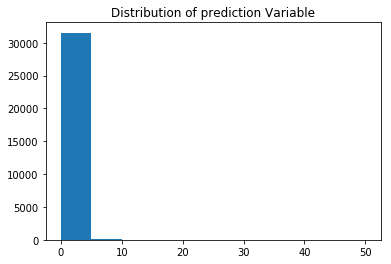

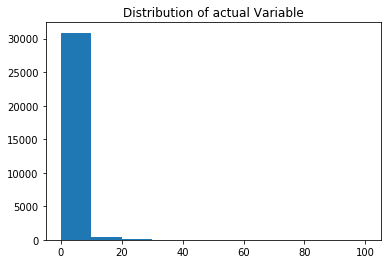

In [48]:
print("Decision Tree Model")
model1 = create_and_fit_model(1, Xtrain, ytrain)
ypred1 = predict_on_model(model1, Xtest)
check_predictions(ypred1, ytest)

print("\nRandom Forest Model")
model2 = create_and_fit_model(0, Xtrain, ytrain)
ypred2 = predict_on_model(model2, Xtest)
check_predictions(ypred2, ytest)

print("\nKNN Model")
model4 = create_and_fit_model(3, Xtrain, ytrain)
ypred4 = predict_on_model(model4, Xtest)
check_predictions(ypred4, ytest)

print("\nLogistic Regression Model")
model5 = create_and_fit_model(4, Xtrain, ytrain)
ypred5 = predict_on_model(model5, Xtest)
check_predictions(ypred5, ytest)

print("\nSupport Vector Model")
model3 = create_and_fit_model(2, Xtrain, ytrain)
ypred3 = predict_on_model(model3, Xtest)
check_predictions(ypred3, ytest)

print("\nStochastic Gradient Descent")
model6 = create_and_fit_model(6, Xtrain, ytrain)
ypred6 = predict_on_model(model6, Xtest)
check_predictions(ypred6, ytest)

MAE:  1.5328213394014096


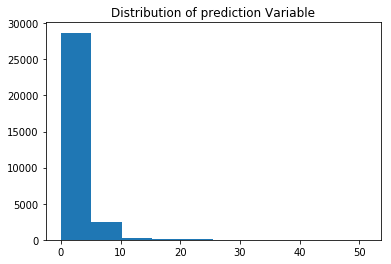

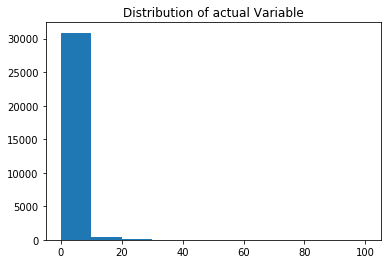

In [56]:
models1 = create_combined_model(0, Xtrain, ytrain, Xtest, ytest)
ypred01, mid01 = predict_on_model(models1, Xtest, num_models=2)
check_predictions(ypred01, ytest)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Training time: 36.71128606796265


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


MAE:  1.070572990739863


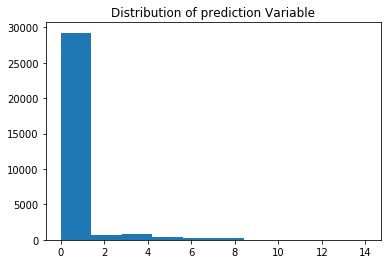

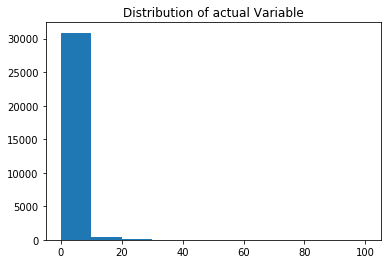

In [63]:
models2 = create_combined_model(0, 1, Xtrain, ytrain, Xtest, ytest)
ypred02, mid02 = predict_on_model(models2, Xtest, num_models=2)
check_predictions(ypred02, ytest)

In [ ]:
# models3 = create_combined_model(1, 1, Xtrain, ytrain, Xtest, ytest)
ypred03, mid03 = predict_on_model(models3, Xtest, num_models=2)
check_predictions(ypred03, ytest)

Training time: 5.316280126571655


In [82]:
from sklearn.metrics import accuracy_score, precision_score
print(accuracy_score(ytest, ypred03), precision_score(ytest, ypred2, average="weighted"))

0.9093265067475743 0.8379418523949083
